# Assignment - Part I

## 3.1 Classification with a single-layer perceptron

### Imports and global settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
plt.style.use('seaborn-whitegrid')

### Helper functions

In [2]:
def generate_data_1(n, mA, mB, sigmaA, sigmaB, dim, Bias):
    """ Function that generates linearly separable data (two classes) and visualizes it.

    Parameters
    ----------
    n : int
        amount of observations per class
    mA : list
        list of integers, specifies centrality of class A for the x, y dimensions
    mB : list
        list of integers, specifies centrality of class B for the x, y dimensions
    sigmaA : int
        specifies spread of class A for both the x, y dimensions
    sigmaB : int
        specifies spread of class B for both the x, y dimensions
    dim : int
        amount of dimensions
    Bias : Boolean (STILL TO DO)
        Adds a row of 1s if set to true, so the data contains biases

    Returns
    -----------
    input_data : array 
        Returns the input data used later on, with the dimensions (dimensions or dimensions+1, datapoints), 
        in our specific case this will be (2,200)
    targets : 1D array
        Returns an 1D array of 1s and -1's that represents the targets
    classA & classB : array
        Returns array of generated data that holds information of which class data belongs to 

    """
    classA = np.zeros((dim, n))
    classB = np.zeros((dim, n))
    
    if Bias == True:
        classA = np.zeros((dim+1, n))
        classB = np.zeros((dim+1, n)) 
        classA[2] = np.ones(n)
        classB[2] = np.ones(n)   
    
    classA[0]= np.random.randn(1,n)*sigmaA +mA[0]
    classA[1]= np.random.randn(1,n)*sigmaA +mA[1]
    classB[0]= np.random.randn(1,n)*sigmaB +mB[0]
    classB[1]= np.random.randn(1,n)*sigmaB +mB[1]
    
    plt.scatter(classA[0], classA[1], marker = 'o', color = 'red', label = "Class A")
    plt.scatter(classB[0], classB[1], marker = 'o', color = 'blue', label = "Class B")
    plt.title("Generated Normally Distributed Data (linearly separable, two classes)")
    
    # Change loc value if legend gets placed in a bad spot.
    plt.legend(loc=2, frameon = True)
    plt.show()
    
    input_data = np.append(classA, classB, axis = 1)
    #Create 100 targets for each class, consisting of 1s and -1s
    targets = np.concatenate(([1]*n, [-1]*n))
    indices = np.arange(targets.shape[0])
    np.random.shuffle(indices)
    # Shuffle data so classes arent lined up in data set
    input_data = input_data[:,indices]
    targets = targets[indices]
    return input_data, targets, classA, classB

### SLP

In [20]:
class SingleLayerPerceptron():
    """ Single Layer Perceptron that can learn with either the perceptron or the delta rule.
    
    Attributes
    ----------
    input_layer_dim : int
        The number of nodes in the input layer.
    if_bias : bool
        Whether SLP uses additional learnable parameter as bias 
        If True, then SLP can have separating hyperplane away from origin.
    learning_rate : float
        The learning rate of the weight update.
    optimizer : str
        The learning rule, either perceptron or delta.
    weights : np.ndarray
        Weight array (1D). If if_bias is True, then of length input_layer_dim + 1, 
        else input_layer_dim.
        
    Methods
    -------
    __init__(self, input_layer_dim, if_bias, learning_rate, optimizer)
        Initialize SLP.
    forward_pass(self, inputs)
        Forward propagation of signals.
    error_func(self, targets, a, h)
        Error function of SLP, either for perceptron or delta learning (optimizer).
    backward_pass(self, inputs, err)
        Backward propagation of signals.
    update_weights(self, dw)
        Weight update rule.
    """
    def __init__(self, input_layer_dim, if_bias, learning_rate, optimizer):
        """ Initialize SLP.

        Parameters
        ----------
        input_layer_dim : int
            The number of nodes in the input layer.
        if_bias : bool
            Whether SLP uses additional learnable parameter as bias 
            If True, then SLP can have separating hyperplane away from origin.
        learning_rate : float
            The learning rate of the weight update.
        optimizer : str
            The learning rule, either perceptron or delta.
        
        Returns
        -----------
        None
        """
        self.input_layer_dim = input_layer_dim
        self.if_bias = if_bias
        self.learning_rate = learning_rate
        assert optimizer in ["perceptron", "delta"], f"optimizer has to be one of perceptron or delta"
        self.optimizer = optimizer
        self.weights = \
            np.random.normal(loc=0, scale=1, size= input_layer_dim + 1 if if_bias else input_layer_dim)
    
    def forward_pass(self, inputs):
        """ Forward propagation of signals.

        Parameters
        ----------
        inputs : np.ndarray
            Array of inputs of shape n_features, n_data. n_features has to be equal to input_layer_dim.
            If bias is used, inputs has an extra 1, and the SLP has a bias parameter. 
        
        Returns
        -----------
        a : np.ndarray
            Array of thresholded outputs of length n_data.
        h : np.ndarray
            Array of non-thresholded outputs of length n_data.
        """
        assert inputs.shape[0] == self.weights.shape[0], \
            f"inputs dim = {inputs.shape[0]} is not equal to weights dim = {self.weights.shape[0]}"
        h = np.dot(self.weights, inputs)
        a = np.heaviside(h, 0)
        a[a == 0] = -1
        a = a.astype(int)
        return a, h
    
    def error_func(self, targets, a, h):
        """ Error function of SLP, either for perceptron or delta learning (optimizer).

        Parameters
        ----------
        targets : np.ndarray
            Array of true output labels of length n_data (1 and -1).
        a : np.ndarray
            Array of thresholded outputs of length n_data.
        h : np.ndarray
            Array of non-thresholded outputs of length n_data.  
        
        Returns
        -----------
        err : np.ndarray
            Array of error values per observation of length n_data. Computed based
            on whether the SLP learns with the perceptron or the delta rule (optimizer).
        """
        if self.optimizer == "perceptron":
            err = a - targets
        else:
            err = h - targets

        return err
        
    def backward_pass(self, inputs, err):
        """ Backward propagation of signals.

        Parameters
        ----------
        inputs : np.ndarray
            Array of inputs of shape n_features, n_data. n_features has to be equal to input_layer_dim.
            If bias is used, inputs has an extra 1, and the SLP has a bias parameter.
        err : np.ndarray
            Array of error values per observation of length n_data. Computed based
            on whether the SLP learns with the perceptron or the delta rule (optimizer).
        
        Returns
        -----------
        dw : np.ndarray
            Weight updates of length input_layer_dim (if_bias=False) 
            or input_layer_dim + 1 (if_bias=True). 
        """
        dw = - self.learning_rate * np.dot(inputs, err)
        return dw
   
    def update_weights(self, dw):
        """ Weight update rule.

        Parameters
        ----------
        dw : np.ndarray
            Weight updates of length input_layer_dim (if_bias=False) 
            or input_layer_dim + 1 (if_bias=True). 
        
        Returns
        -----------
        None
        """
        self.weights += dw
    

def plot_slp_data_and_dec_boundary(input_data, classA, classB, if_bias, slp, title, indices_misclassified):
    """ Plot data used for training the SLP and the learned decision boundary (separating hyperplane).
    Colors misclassified points to green for debugging.

    Parameters
    ----------
    input_data : array 
        Array of inputs of shape n_features, n_data. n_features has to be equal to input_layer_dim.
        If bias is used, inputs has an extra 1, and the SLP has a bias parameter. 
    classA & classB : array
        Returns array of generated data that holds information of which class data belongs to
    if_bias : bool
        Whether SLP uses additional learnable parameter as bias 
        If True, then SLP can have separating hyperplane away from origin.
    slp : object of class SLP
        SLP.
    title : str
        The title of the plot.
    indices_misclassified : np.ndarray or NoneType
        Array of indices of miscalssified data points. If NoneType, then the initialized SLP's 
        decision boundary is shown (say no misclassified points yet).
    Returns
    -----------
    None
    """
    x = np.linspace(-3,3, 1000)
    if if_bias:
        y = (-slp.weights[2]/ slp.weights[1]) + \
            (-(slp.weights[2]/slp.weights[1]) / (slp.weights[2]/slp.weights[0])) * x 
    else:
        y=(slp.weights[0]/slp.weights[1]) * x
    
    plt.scatter(classA[0], classA[1], marker = 'o', color = 'red', label = "Class A")
    plt.scatter(classB[0], classB[1], marker = 'o', color = 'blue', label = "Class B")
    
    # Color misclassified points to green for debugging.
    if indices_misclassified is not None:
        plt.scatter(input_data[0, indices_misclassified], 
                    input_data[1, indices_misclassified], color='green')
    
    plt.plot(x,y,'k-',)
    plt.xlim(-3,4)
    plt.ylim(-2,4)
    plt.title(title)
    plt.show()

    
def compute_metrics(slp, input_data, targets, err):
    """ Compute accuracy, misclassification rate, and MSE (MSE only really makes sense in the case
    of delta learning so just ignore for perceptron learning).

    Parameters
    ----------
    slp : object of class SLP
        SLP.
    input_data : array 
        Array of inputs of shape n_features, n_data. n_features has to be equal to input_layer_dim.
        If bias is used, inputs has an extra 1, and the SLP has a bias parameter. 
    targets : np.ndarray
            Array of true output labels of length n_data (1 and -1).
    err : np.ndarray
            Array of error values per observation of length n_data. Computed based
            on whether the SLP learns with the perceptron or the delta rule (optimizer).
    
    Returns
    -----------
    accuracy : float
        Accuracy of SLP per epoch.
    indices_misclassified : np.ndarray
        Array (1D) of indicies of misclassified points at the end of an epoch.
    mse : float
        MSE at the end of an epoch. Only really makes sense for delta learning.
    """
    a, h = slp.forward_pass(inputs=input_data)
    err = slp.error_func(targets=targets, a=a, h=h)
    
    accuracy = np.sum(a == targets) / targets.shape[0]
    indices_misclassified = np.argwhere(a != targets)
    
    mse = np.mean(np.square(err))
    
    return accuracy, indices_misclassified, mse
    
def plot_slp_accuracy_vs_n_epohcs(accuracies, title="(train)"):
    """ Plots accuracy vs epochs.

    Parameters
    ----------
    accuracies : list
        List of accuracies over epochs.
    
    Returns
    -----------
    None
    """
    plt.plot(accuracies)
    plt.title(f"Accuracy (real number) vs. number of epochs {title}")
    plt.show()
    
def plot_slp_misclassification_vs_n_epohcs(misclassifications, title="(train)"):
    """ Plots number of misclassifications vs epochs.

    Parameters
    ----------
    misclassifications : list
        List of number of misclassifications over epochs.
    
    Returns
    -----------
    None
    """
    plt.plot(misclassifications)
    plt.title(f"Number of missclassifications vs. number of epochs {title}")
    plt.show()
    
def plot_slp_mse_vs_n_epochs(mses, title="(train)"):
    """ Plots MSE vs epochs. Only makes real sense for delta learning. Just ignore
    for perceptron learning.

    Parameters
    ----------
    mses : list
        List of MSE values over epochs.
    
    Returns
    -----------
    None
    """
    plt.plot(mses)
    plt.title(f"MSE vs. number of epochs {title}")
    plt.show()
    
    
def train_loop_1(input_data, targets, classA, classB, slp, n_epochs, batch_size, thresh):
    """ Plots MSE vs epochs. Only makes real sense for delta learning. Just ignore
    for perceptron learning.

    Parameters
    ----------
    input_data : array 
        Array of inputs of shape n_features, n_data. n_features has to be equal to input_layer_dim.
        If bias is used, inputs has an extra 1, and the SLP has a bias parameter.
    targets : np.ndarray
            Array of true output labels of length n_data (1 and -1).
    classA & classB : array
        Returns array of generated data that holds information of which class data belongs to
    slp : object of class SLP
        SLP.
    n_epochs : int
        The number of epochs.
    batch_size : int
        The batch size. batch_size = 1 -> stochastic optimization, 
        batch_size = input_data.shape[1] -> batch mode,
        1 < batch_size < input_data.shape[1] -> mini-batch mode.
    thresh : float
        Threshold for convergence.
    
    Returns
    -----------
    None
    """
    assert 1 <= batch_size <= input_data.shape[1] and isinstance(batch_size, int), \
        f"batch_size is incorrect, needs to be greater than 1 and less " \
        f"than the number of data points, and is int"
    
    # Lists to store performance metrics to be plotted at the end of training.
    accuracies = []
    misclassifications = []
    mses = []

    # plot initialized network decision boundary (some random line)
    plot_slp_data_and_dec_boundary(input_data=input_data, classA=classA, classB=classB, 
                                   if_bias=slp.if_bias, slp=slp, title="initialized", 
                                   indices_misclassified=None)

    # iterate over epochs
    for i in range(n_epochs):

        # Shuffle data
        indices = np.arange(input_data.shape[1])
        np.random.shuffle(indices)
        input_data = input_data[:,indices]
        targets = targets[indices]

        # Assert that batch_size is okay
        assert input_data.shape[1] % batch_size == 0, \
            f"n_data is {input_data.shape[1]}, has to be divisible by batch_size = {batch_size}"
        n_batch = int(input_data.shape[1] / batch_size)

        # Iterate over mini-batches (if batch_size is the number of observations in the dataset, then 
        # it is batch mode, if batch_size = 1 then stochastic mode)
        print(f"epoch:{i+1}")

        for b in range(n_batch):
            input_data_batch = input_data[:, b*batch_size:(b+1)*batch_size]
            targets_batch = targets[b*batch_size:(b+1)*batch_size]
            a_batch, h_batch = slp.forward_pass(inputs=input_data_batch)
            err = slp.error_func(targets=targets_batch, a=a_batch, h=h_batch)
            dw = slp.backward_pass(inputs=input_data_batch, err=err)
            slp.update_weights(dw=dw)
            print(f"\tbatch {b+1}/{n_batch}")

        # be careful could end up with exploding gradients so make sure to look at the magntidue of the grads
        #print(dw)

        # Compute accuracy and classification performance metrics 
        accuracy, indices_misclassified, mse = compute_metrics(slp=slp, input_data=input_data, 
                                                               targets=targets, err=err)
        accuracies.append(accuracy)
        misclassifications.append(indices_misclassified.shape[0])
        mses.append(mse)
        print(f"accuracy = {accuracy}, misclassified: {indices_misclassified.shape[0]}\n")

        if i % 10 == 0:
            # Plot boundary at the end of the epoch.
            plot_slp_data_and_dec_boundary(input_data=input_data, classA=classA, classB=classB, 
                                           if_bias=slp.if_bias, slp=slp, title=f"epoch: {i+1}", 
                                           indices_misclassified=indices_misclassified)

        # Check convergence.
        if np.abs(np.sum(dw)) < thresh and accuracy == 1.0:
            print(f"slp converged after {i+1} epochs.")
            # Plot boundary at the end of the epoch.
            plot_slp_data_and_dec_boundary(input_data=input_data, classA=classA, classB=classB, 
                                           if_bias=slp.if_bias, slp=slp, title=f"epoch: {i+1}", 
                                           indices_misclassified=indices_misclassified)
            break

    # Plot accuracy and miscassification rate vs. number of epochs.    
    plot_slp_accuracy_vs_n_epohcs(accuracies=accuracies)
    plot_slp_misclassification_vs_n_epohcs(misclassifications=misclassifications)
    plot_slp_mse_vs_n_epochs(mses)

### 3.1.1 Generation of linearly-separable data

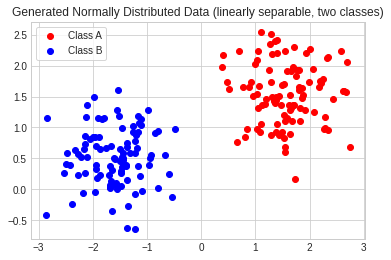

In [21]:
n = 100
mA = [1.5, 1.5]
mB = [-1.5, 0.5]
sigmaA = sigmaB = 0.5
dim = 2
# also used in perceptron instantiation
if_bias = True
input_data, targets, classA, classB = generate_data_1(n, mA, mB, sigmaA, sigmaB, dim, if_bias)

### 3.1.2 Classification with a single-layer perceptron and analysis

SLP with perceptron learning rule.

In [22]:
input_layer_dim = 2
learning_rate = 0.001
n_epochs = 200
# if batch_size is equal to the number of observations in the dataset,
# then we do batch_mode. if batch_mode = 1, we do stochastic optimization (these are the 2 extremes).
# in between, we do mini-batch optimization
batch_size = 200
thresh = 10e-4
optimizer = "perceptron"
#optimizer = "delta"

slp = SingleLayerPerceptron(input_layer_dim=input_layer_dim, 
                            if_bias=if_bias, 
                            learning_rate=learning_rate,
                            optimizer=optimizer)

Train the SLP on the linearly separable data.

Note that if the learning is too big, the misclassified points will once be on one side of the decision boundary then on the other = exploding gradients (print dw).
This means that we need to lower the learning rate. 

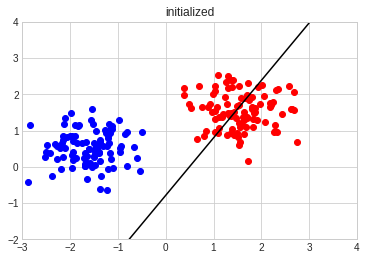

epoch:1
	batch 1/1
accuracy = 0.43, misclassified: 114



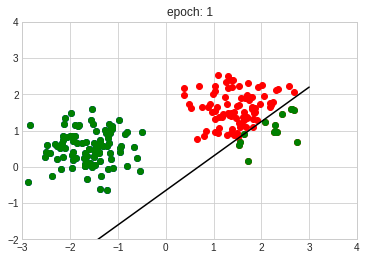

epoch:2
	batch 1/1
accuracy = 0.49, misclassified: 102

epoch:3
	batch 1/1
accuracy = 0.505, misclassified: 99

epoch:4
	batch 1/1
accuracy = 0.63, misclassified: 74

epoch:5
	batch 1/1
accuracy = 0.93, misclassified: 14

epoch:6
	batch 1/1
accuracy = 0.965, misclassified: 7

epoch:7
	batch 1/1
accuracy = 0.98, misclassified: 4

epoch:8
	batch 1/1
accuracy = 0.98, misclassified: 4

epoch:9
	batch 1/1
accuracy = 0.99, misclassified: 2

epoch:10
	batch 1/1
accuracy = 0.99, misclassified: 2

epoch:11
	batch 1/1
accuracy = 0.99, misclassified: 2



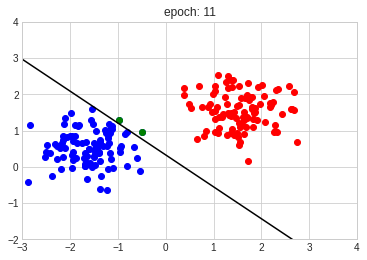

epoch:12
	batch 1/1
accuracy = 0.99, misclassified: 2

epoch:13
	batch 1/1
accuracy = 0.99, misclassified: 2

epoch:14
	batch 1/1
accuracy = 0.99, misclassified: 2

epoch:15
	batch 1/1
accuracy = 0.995, misclassified: 1

epoch:16
	batch 1/1
accuracy = 0.995, misclassified: 1

epoch:17
	batch 1/1
accuracy = 0.995, misclassified: 1

epoch:18
	batch 1/1
accuracy = 0.995, misclassified: 1

epoch:19
	batch 1/1
accuracy = 0.995, misclassified: 1

epoch:20
	batch 1/1
accuracy = 0.995, misclassified: 1

epoch:21
	batch 1/1
accuracy = 0.995, misclassified: 1



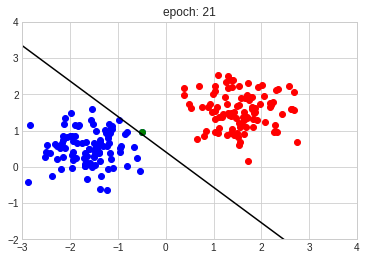

epoch:22
	batch 1/1
accuracy = 0.995, misclassified: 1

epoch:23
	batch 1/1
accuracy = 0.995, misclassified: 1

epoch:24
	batch 1/1
accuracy = 0.995, misclassified: 1

epoch:25
	batch 1/1
accuracy = 0.995, misclassified: 1

epoch:26
	batch 1/1
accuracy = 0.995, misclassified: 1

epoch:27
	batch 1/1
accuracy = 0.995, misclassified: 1

epoch:28
	batch 1/1
accuracy = 0.995, misclassified: 1

epoch:29
	batch 1/1
accuracy = 0.995, misclassified: 1

epoch:30
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:31
	batch 1/1
accuracy = 1.0, misclassified: 0



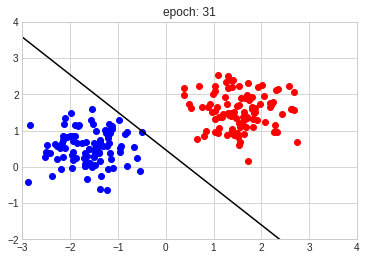

slp converged after 31 epochs.


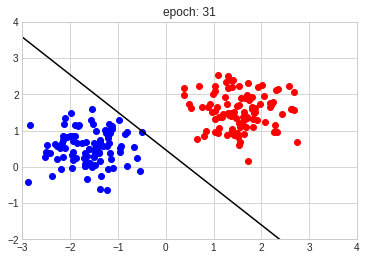

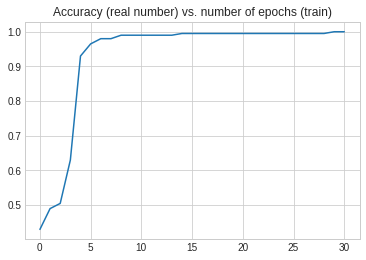

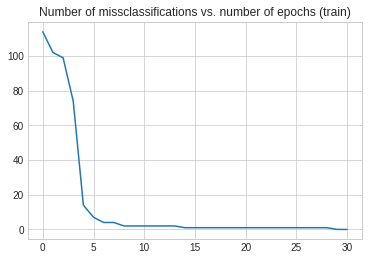

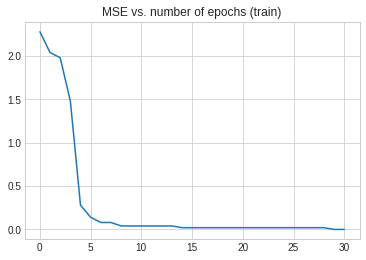

In [23]:
train_loop_1(input_data=input_data,
             targets=targets,
             classA=classA, 
             classB=classB, 
             slp=slp, 
             n_epochs=n_epochs, 
             batch_size=batch_size, 
             thresh=thresh)

SLP with delta learning rule.

In [24]:
input_layer_dim = 2
learning_rate = 0.001
n_epochs = 200
# if batch_size is equal to the number of observations in the dataset,
# then we do batch_mode. if batch_mode = 1, we do stochastic optimization (these are the 2 extremes).
# in between, we do mini-batch optimization
batch_size = 200
thresh = 10e-4
#optimizer = "perceptron"
optimizer = "delta"

slp = SingleLayerPerceptron(input_layer_dim=input_layer_dim, 
                            if_bias=if_bias, 
                            learning_rate=learning_rate,
                            optimizer=optimizer)

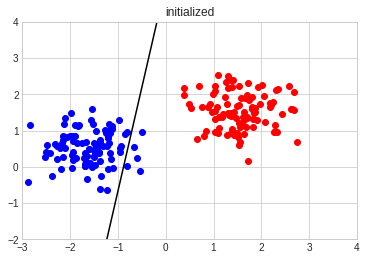

epoch:1
	batch 1/1
accuracy = 0.96, misclassified: 8



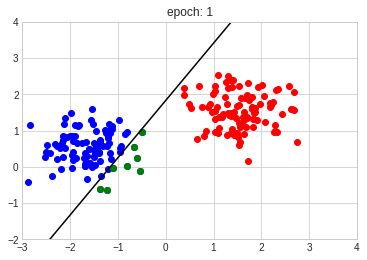

epoch:2
	batch 1/1
accuracy = 0.94, misclassified: 12

epoch:3
	batch 1/1
accuracy = 0.925, misclassified: 15

epoch:4
	batch 1/1
accuracy = 0.915, misclassified: 17

epoch:5
	batch 1/1
accuracy = 0.915, misclassified: 17

epoch:6
	batch 1/1
accuracy = 0.915, misclassified: 17

epoch:7
	batch 1/1
accuracy = 0.915, misclassified: 17

epoch:8
	batch 1/1
accuracy = 0.92, misclassified: 16

epoch:9
	batch 1/1
accuracy = 0.92, misclassified: 16

epoch:10
	batch 1/1
accuracy = 0.925, misclassified: 15

epoch:11
	batch 1/1
accuracy = 0.935, misclassified: 13



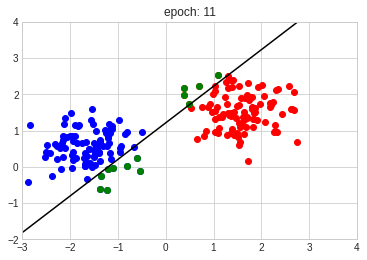

epoch:12
	batch 1/1
accuracy = 0.935, misclassified: 13

epoch:13
	batch 1/1
accuracy = 0.935, misclassified: 13

epoch:14
	batch 1/1
accuracy = 0.94, misclassified: 12

epoch:15
	batch 1/1
accuracy = 0.945, misclassified: 11

epoch:16
	batch 1/1
accuracy = 0.95, misclassified: 10

epoch:17
	batch 1/1
accuracy = 0.955, misclassified: 9

epoch:18
	batch 1/1
accuracy = 0.955, misclassified: 9

epoch:19
	batch 1/1
accuracy = 0.955, misclassified: 9

epoch:20
	batch 1/1
accuracy = 0.96, misclassified: 8

epoch:21
	batch 1/1
accuracy = 0.96, misclassified: 8



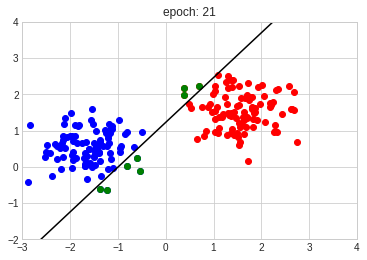

epoch:22
	batch 1/1
accuracy = 0.96, misclassified: 8

epoch:23
	batch 1/1
accuracy = 0.96, misclassified: 8

epoch:24
	batch 1/1
accuracy = 0.96, misclassified: 8

epoch:25
	batch 1/1
accuracy = 0.96, misclassified: 8

epoch:26
	batch 1/1
accuracy = 0.965, misclassified: 7

epoch:27
	batch 1/1
accuracy = 0.965, misclassified: 7

epoch:28
	batch 1/1
accuracy = 0.97, misclassified: 6

epoch:29
	batch 1/1
accuracy = 0.97, misclassified: 6

epoch:30
	batch 1/1
accuracy = 0.975, misclassified: 5

epoch:31
	batch 1/1
accuracy = 0.98, misclassified: 4



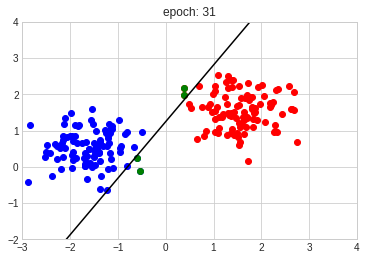

epoch:32
	batch 1/1
accuracy = 0.98, misclassified: 4

epoch:33
	batch 1/1
accuracy = 0.98, misclassified: 4

epoch:34
	batch 1/1
accuracy = 0.98, misclassified: 4

epoch:35
	batch 1/1
accuracy = 0.985, misclassified: 3

epoch:36
	batch 1/1
accuracy = 0.985, misclassified: 3

epoch:37
	batch 1/1
accuracy = 0.985, misclassified: 3

epoch:38
	batch 1/1
accuracy = 0.99, misclassified: 2

epoch:39
	batch 1/1
accuracy = 0.99, misclassified: 2

epoch:40
	batch 1/1
accuracy = 0.99, misclassified: 2

epoch:41
	batch 1/1
accuracy = 0.99, misclassified: 2



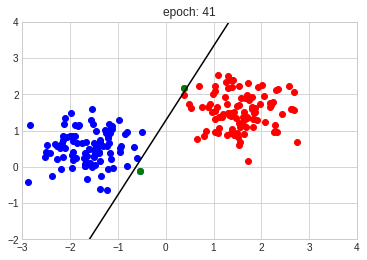

epoch:42
	batch 1/1
accuracy = 0.99, misclassified: 2

epoch:43
	batch 1/1
accuracy = 0.99, misclassified: 2

epoch:44
	batch 1/1
accuracy = 0.995, misclassified: 1

epoch:45
	batch 1/1
accuracy = 0.995, misclassified: 1

epoch:46
	batch 1/1
accuracy = 0.995, misclassified: 1

epoch:47
	batch 1/1
accuracy = 0.995, misclassified: 1

epoch:48
	batch 1/1
accuracy = 0.995, misclassified: 1

epoch:49
	batch 1/1
accuracy = 0.995, misclassified: 1

epoch:50
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:51
	batch 1/1
accuracy = 1.0, misclassified: 0



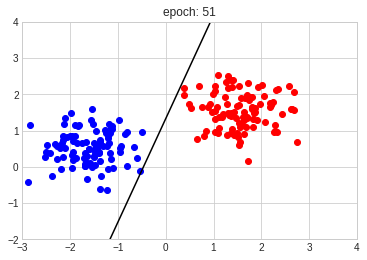

epoch:52
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:53
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:54
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:55
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:56
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:57
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:58
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:59
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:60
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:61
	batch 1/1
accuracy = 1.0, misclassified: 0



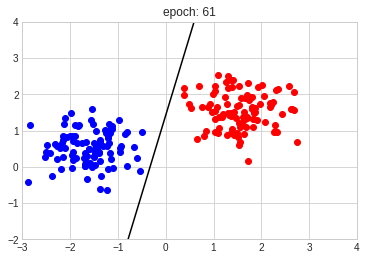

epoch:62
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:63
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:64
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:65
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:66
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:67
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:68
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:69
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:70
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:71
	batch 1/1
accuracy = 1.0, misclassified: 0



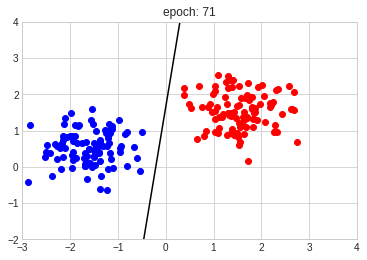

epoch:72
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:73
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:74
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:75
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:76
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:77
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:78
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:79
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:80
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:81
	batch 1/1
accuracy = 1.0, misclassified: 0



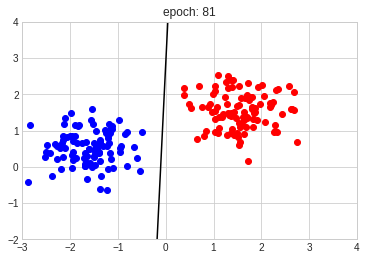

epoch:82
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:83
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:84
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:85
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:86
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:87
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:88
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:89
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:90
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:91
	batch 1/1
accuracy = 1.0, misclassified: 0



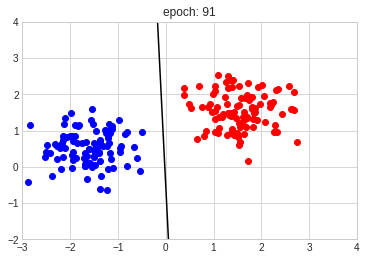

epoch:92
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:93
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:94
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:95
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:96
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:97
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:98
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:99
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:100
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:101
	batch 1/1
accuracy = 1.0, misclassified: 0



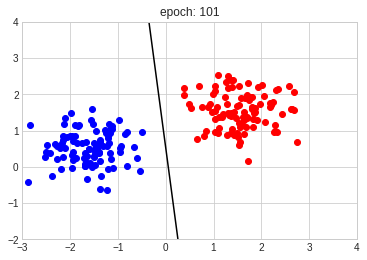

epoch:102
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:103
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:104
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:105
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:106
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:107
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:108
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:109
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:110
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:111
	batch 1/1
accuracy = 1.0, misclassified: 0



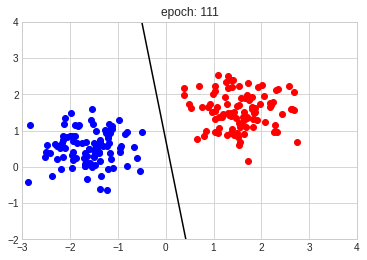

epoch:112
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:113
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:114
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:115
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:116
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:117
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:118
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:119
	batch 1/1
accuracy = 1.0, misclassified: 0

epoch:120
	batch 1/1
accuracy = 1.0, misclassified: 0

slp converged after 120 epochs.


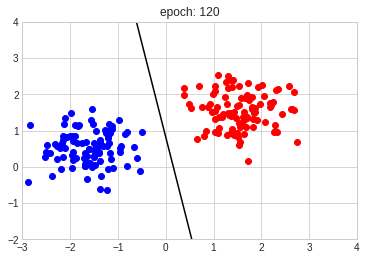

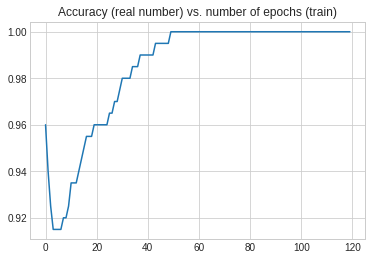

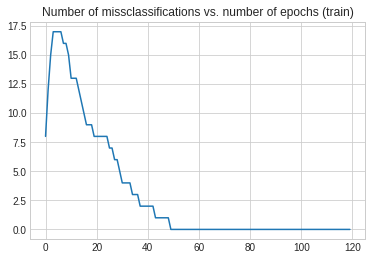

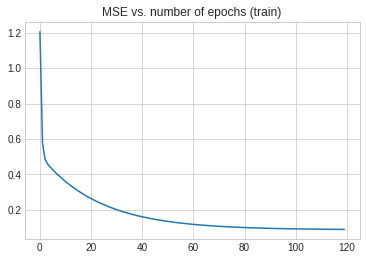

In [25]:
train_loop_1(input_data=input_data,
             targets=targets,
             classA=classA, 
             classB=classB, 
             slp=slp, 
             n_epochs=n_epochs, 
             batch_size=batch_size, 
             thresh=thresh)

### 3.1.3 Classification of samples that are not linearly separable

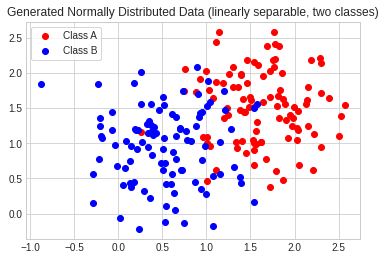

In [26]:
n = 100
mA = [1.5, 1.5]
mB = [0.5, 1.0]
sigmaA = sigmaB = 0.5
dim = 2
# also used in perceptron instantiation
if_bias = True

input_data, targets, classA, classB = generate_data_1(n, mA, mB, sigmaA, sigmaB, dim, if_bias)

SLP with perceptron learning rule

In [27]:
input_layer_dim = 2
learning_rate = 0.001
n_epochs = 50
# if batch_size is equal to the number of observations in the dataset,
# then we do batch_mode. if batch_mode = 1, we do stochastic optimization (these are the 2 extremes).
# in between, we do mini-batch optimization
batch_size = 200
thresh = 10e-4
optimizer = "perceptron"
#optimizer = "delta"

slp = SingleLayerPerceptron(input_layer_dim=input_layer_dim, if_bias=if_bias, learning_rate=learning_rate,
                           optimizer=optimizer)

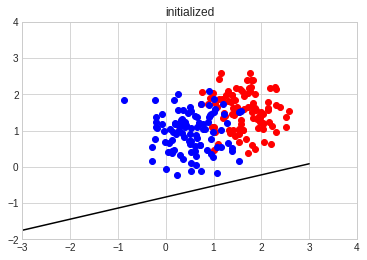

epoch:1
	batch 1/1
accuracy = 0.525, misclassified: 95



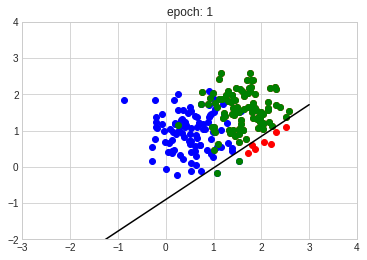

epoch:2
	batch 1/1
accuracy = 0.8, misclassified: 40

epoch:3
	batch 1/1
accuracy = 0.83, misclassified: 34

epoch:4
	batch 1/1
accuracy = 0.83, misclassified: 34

epoch:5
	batch 1/1
accuracy = 0.825, misclassified: 35

epoch:6
	batch 1/1
accuracy = 0.835, misclassified: 33

epoch:7
	batch 1/1
accuracy = 0.83, misclassified: 34

epoch:8
	batch 1/1
accuracy = 0.84, misclassified: 32

epoch:9
	batch 1/1
accuracy = 0.84, misclassified: 32

epoch:10
	batch 1/1
accuracy = 0.84, misclassified: 32

epoch:11
	batch 1/1
accuracy = 0.835, misclassified: 33



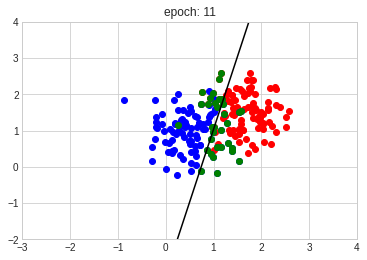

epoch:12
	batch 1/1
accuracy = 0.845, misclassified: 31

epoch:13
	batch 1/1
accuracy = 0.85, misclassified: 30

epoch:14
	batch 1/1
accuracy = 0.86, misclassified: 28

epoch:15
	batch 1/1
accuracy = 0.86, misclassified: 28

epoch:16
	batch 1/1
accuracy = 0.87, misclassified: 26

epoch:17
	batch 1/1
accuracy = 0.86, misclassified: 28

epoch:18
	batch 1/1
accuracy = 0.89, misclassified: 22

epoch:19
	batch 1/1
accuracy = 0.86, misclassified: 28

epoch:20
	batch 1/1
accuracy = 0.875, misclassified: 25

epoch:21
	batch 1/1
accuracy = 0.875, misclassified: 25



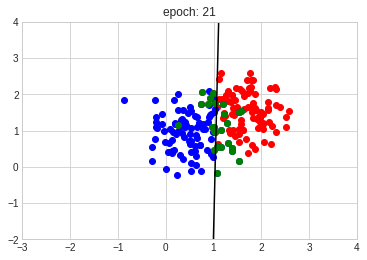

epoch:22
	batch 1/1
accuracy = 0.875, misclassified: 25

epoch:23
	batch 1/1
accuracy = 0.88, misclassified: 24

epoch:24
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:25
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:26
	batch 1/1
accuracy = 0.88, misclassified: 24

epoch:27
	batch 1/1
accuracy = 0.88, misclassified: 24

epoch:28
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:29
	batch 1/1
accuracy = 0.88, misclassified: 24

epoch:30
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:31
	batch 1/1
accuracy = 0.885, misclassified: 23



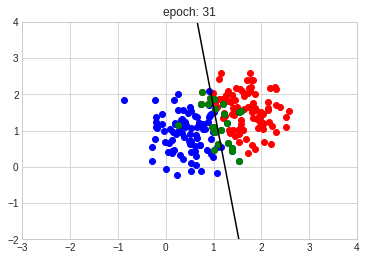

epoch:32
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:33
	batch 1/1
accuracy = 0.89, misclassified: 22

epoch:34
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:35
	batch 1/1
accuracy = 0.89, misclassified: 22

epoch:36
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:37
	batch 1/1
accuracy = 0.89, misclassified: 22

epoch:38
	batch 1/1
accuracy = 0.895, misclassified: 21

epoch:39
	batch 1/1
accuracy = 0.89, misclassified: 22

epoch:40
	batch 1/1
accuracy = 0.895, misclassified: 21

epoch:41
	batch 1/1
accuracy = 0.895, misclassified: 21



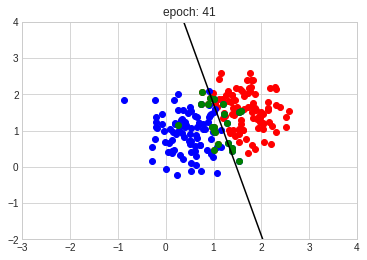

epoch:42
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:43
	batch 1/1
accuracy = 0.91, misclassified: 18

epoch:44
	batch 1/1
accuracy = 0.895, misclassified: 21

epoch:45
	batch 1/1
accuracy = 0.91, misclassified: 18

epoch:46
	batch 1/1
accuracy = 0.9, misclassified: 20

epoch:47
	batch 1/1
accuracy = 0.905, misclassified: 19

epoch:48
	batch 1/1
accuracy = 0.905, misclassified: 19

epoch:49
	batch 1/1
accuracy = 0.9, misclassified: 20

epoch:50
	batch 1/1
accuracy = 0.905, misclassified: 19



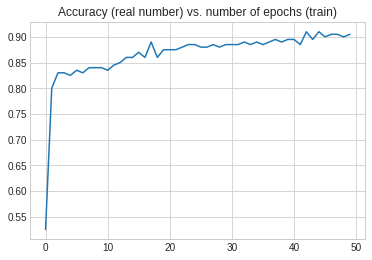

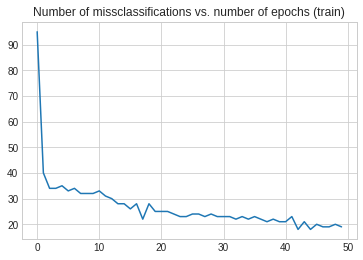

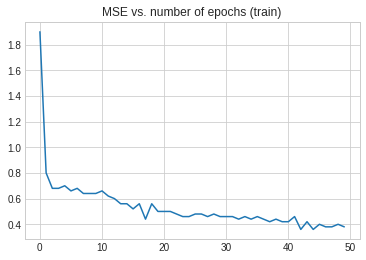

In [28]:
train_loop_1(input_data=input_data,
             targets=targets,
             classA=classA, 
             classB=classB, 
             slp=slp, 
             n_epochs=n_epochs, 
             batch_size=batch_size, 
             thresh=thresh)

SLP with delta learning rule

In [29]:
input_layer_dim = 2
learning_rate = 0.001
n_epochs = 50
# if batch_size is equal to the number of observations in the dataset,
# then we do batch_mode. if batch_mode = 1, we do stochastic optimization (these are the 2 extremes).
# in between, we do mini-batch optimization
batch_size = 200
thresh = 10e-4
#optimizer = "perceptron"
optimizer = "delta"

slp = SingleLayerPerceptron(input_layer_dim=input_layer_dim, if_bias=if_bias, learning_rate=learning_rate,
                           optimizer=optimizer)

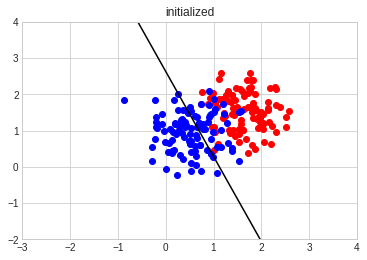

epoch:1
	batch 1/1
accuracy = 0.875, misclassified: 25



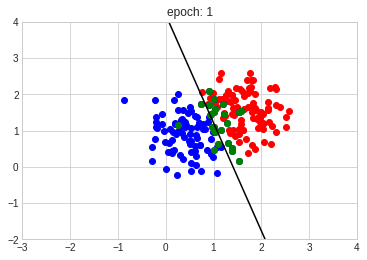

epoch:2
	batch 1/1
accuracy = 0.88, misclassified: 24

epoch:3
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:4
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:5
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:6
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:7
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:8
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:9
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:10
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:11
	batch 1/1
accuracy = 0.885, misclassified: 23



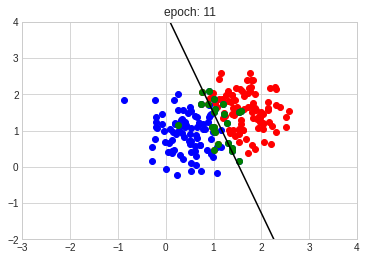

epoch:12
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:13
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:14
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:15
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:16
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:17
	batch 1/1
accuracy = 0.89, misclassified: 22

epoch:18
	batch 1/1
accuracy = 0.89, misclassified: 22

epoch:19
	batch 1/1
accuracy = 0.89, misclassified: 22

epoch:20
	batch 1/1
accuracy = 0.89, misclassified: 22

epoch:21
	batch 1/1
accuracy = 0.885, misclassified: 23



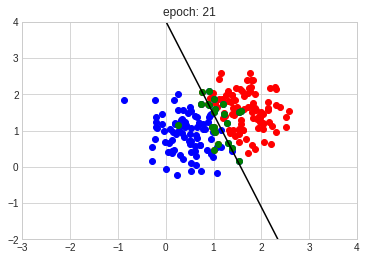

epoch:22
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:23
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:24
	batch 1/1
accuracy = 0.885, misclassified: 23

epoch:25
	batch 1/1
accuracy = 0.89, misclassified: 22

epoch:26
	batch 1/1
accuracy = 0.89, misclassified: 22

epoch:27
	batch 1/1
accuracy = 0.89, misclassified: 22

epoch:28
	batch 1/1
accuracy = 0.89, misclassified: 22

epoch:29
	batch 1/1
accuracy = 0.895, misclassified: 21

epoch:30
	batch 1/1
accuracy = 0.895, misclassified: 21

epoch:31
	batch 1/1
accuracy = 0.895, misclassified: 21



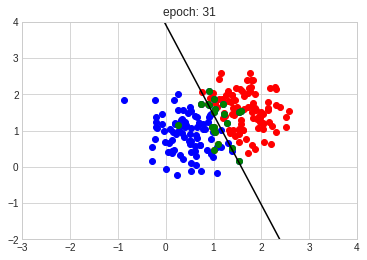

epoch:32
	batch 1/1
accuracy = 0.895, misclassified: 21

epoch:33
	batch 1/1
accuracy = 0.895, misclassified: 21

epoch:34
	batch 1/1
accuracy = 0.895, misclassified: 21

epoch:35
	batch 1/1
accuracy = 0.895, misclassified: 21

epoch:36
	batch 1/1
accuracy = 0.895, misclassified: 21

epoch:37
	batch 1/1
accuracy = 0.895, misclassified: 21

epoch:38
	batch 1/1
accuracy = 0.895, misclassified: 21

epoch:39
	batch 1/1
accuracy = 0.895, misclassified: 21

epoch:40
	batch 1/1
accuracy = 0.895, misclassified: 21

epoch:41
	batch 1/1
accuracy = 0.9, misclassified: 20



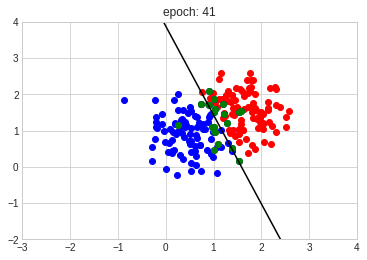

epoch:42
	batch 1/1
accuracy = 0.9, misclassified: 20

epoch:43
	batch 1/1
accuracy = 0.9, misclassified: 20

epoch:44
	batch 1/1
accuracy = 0.9, misclassified: 20

epoch:45
	batch 1/1
accuracy = 0.9, misclassified: 20

epoch:46
	batch 1/1
accuracy = 0.9, misclassified: 20

epoch:47
	batch 1/1
accuracy = 0.9, misclassified: 20

epoch:48
	batch 1/1
accuracy = 0.9, misclassified: 20

epoch:49
	batch 1/1
accuracy = 0.9, misclassified: 20

epoch:50
	batch 1/1
accuracy = 0.9, misclassified: 20



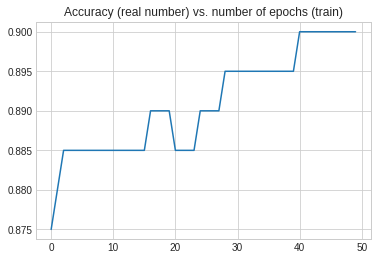

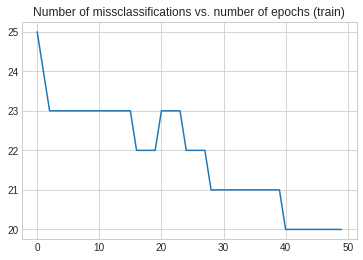

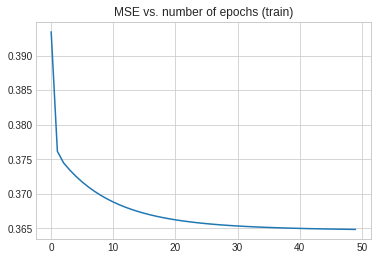

In [30]:
train_loop_1(input_data=input_data,
             targets=targets,
             classA=classA, 
             classB=classB, 
             slp=slp, 
             n_epochs=n_epochs, 
             batch_size=batch_size, 
             thresh=thresh)

That random data at the end of section 3.1.3.

In [31]:
def generate_data_2(n, mA, mB, sigmaA, sigmaB, dim, Bias):
    """ Function that generates linearly separable data (two classes) and visualizes it.

        Parameters
        ----------
        n : int
            amount of observations per class
        mA : list
            list of integers, specifies centrality of class A for the x, y dimensions
        mB : list
            list of integers, specifies centrality of class B for the x, y dimensions
        sigmaA : int
            specifies spread of class A for both the x, y dimensions
        sigmaB : int
            specifies spread of class B for both the x, y dimensions
        dim : int
            amount of dimensions
        Bias : Boolean (STILL TO DO)
            Adds a row of 1s if set to true, so the data contains biases
        
        Returns
        -----------
        input_data : array 
            Returns the input data used later on, with the dimensions (dimensions or dimensions+1, datapoints), 
            in our specific case this will be (2,200)
        targets : 1D array
            Returns an 1D array of 1s and -1's that represents the targets
        classA & classB : array
            Returns array of generated data that holds information of which class data belongs to 

    """
    classA = np.zeros((dim, n))
    classB = np.zeros((dim, n))
    
    if Bias == True:
        classA = np.zeros((dim+1, n))
        classB = np.zeros((dim+1, n)) 
        classA[2] = np.ones(n)
        classB[2] = np.ones(n)
    
    classA[0]= np.concatenate((np.random.randn(1,int(0.5*n))*sigmaA - mA[0], 
                               np.random.randn(1,int(0.5*n))*sigmaA + mA[0]), axis=1)

    classA[1]= np.random.randn(1,n)*sigmaA +mA[1]
    classB[0]= np.random.randn(1,n)*sigmaB +mB[0]
    classB[1]= np.random.randn(1,n)*sigmaB +mB[1]
    
    plt.scatter(classA[0], classA[1], marker = 'o', color = 'red', label = "Class A")
    plt.scatter(classB[0], classB[1], marker = 'o', color = 'blue', label = "Class B")
    plt.title("Generated Normally Distributed Data (linearly separable, two classes)")
    
    # Change loc value if legend gets placed in a bad spot.
    plt.legend(loc=2, frameon = True)
    plt.show()
    
    input_data = np.append(classA, classB, axis = 1)
    #Create 100 targets for each class, consisting of 1s and -1s
    targets = np.concatenate(([1]*n, [-1]*n))
    
    # Do not shuffle data so classes arent lined up in data set, because makes subsampling harder.
    # We shuffle at the beggining of each epoch anyway.
    return input_data, targets, classA, classB

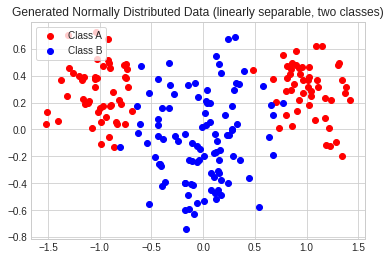

In [32]:
n = 100
mA = [1.0, 0.3]
mB = [0.0, -0.1]
sigmaA = 0.2
sigmaB = 0.3
dim = 2
# also used in perceptron instantiation
if_bias = True

input_data, targets, classA, classB = generate_data_2(n, mA, mB, sigmaA, sigmaB, dim, if_bias)

Sub-sample 1: full dataset

In [33]:
input_layer_dim = 2
learning_rate = 0.001
n_epochs = 50
# if batch_size is equal to the number of observations in the dataset,
# then we do batch_mode. if batch_mode = 1, we do stochastic optimization (these are the 2 extremes).
# in between, we do mini-batch optimization
batch_size = 200
thresh = 10e-4
#optimizer = "perceptron"
optimizer = "delta"

slp = SingleLayerPerceptron(input_layer_dim=input_layer_dim, if_bias=if_bias, learning_rate=learning_rate,
                           optimizer=optimizer)

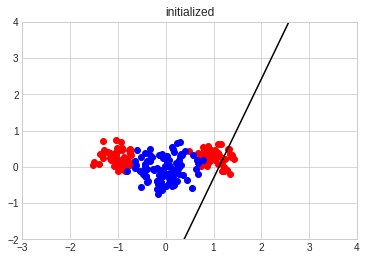

epoch:1
	batch 1/1
accuracy = 0.58, misclassified: 84



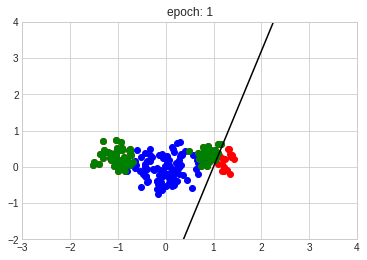

epoch:2
	batch 1/1
accuracy = 0.635, misclassified: 73

epoch:3
	batch 1/1
accuracy = 0.685, misclassified: 63

epoch:4
	batch 1/1
accuracy = 0.73, misclassified: 54

epoch:5
	batch 1/1
accuracy = 0.725, misclassified: 55

epoch:6
	batch 1/1
accuracy = 0.715, misclassified: 57

epoch:7
	batch 1/1
accuracy = 0.71, misclassified: 58

epoch:8
	batch 1/1
accuracy = 0.695, misclassified: 61

epoch:9
	batch 1/1
accuracy = 0.675, misclassified: 65

epoch:10
	batch 1/1
accuracy = 0.67, misclassified: 66

epoch:11
	batch 1/1
accuracy = 0.665, misclassified: 67



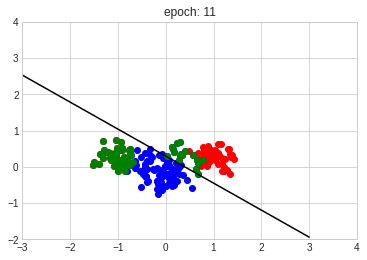

epoch:12
	batch 1/1
accuracy = 0.635, misclassified: 73

epoch:13
	batch 1/1
accuracy = 0.625, misclassified: 75

epoch:14
	batch 1/1
accuracy = 0.645, misclassified: 71

epoch:15
	batch 1/1
accuracy = 0.67, misclassified: 66

epoch:16
	batch 1/1
accuracy = 0.685, misclassified: 63

epoch:17
	batch 1/1
accuracy = 0.705, misclassified: 59

epoch:18
	batch 1/1
accuracy = 0.71, misclassified: 58

epoch:19
	batch 1/1
accuracy = 0.705, misclassified: 59

epoch:20
	batch 1/1
accuracy = 0.705, misclassified: 59

epoch:21
	batch 1/1
accuracy = 0.715, misclassified: 57



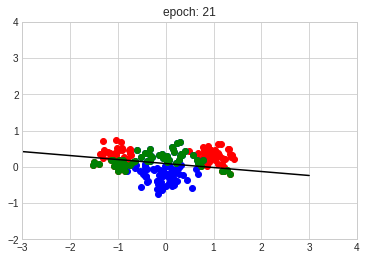

epoch:22
	batch 1/1
accuracy = 0.72, misclassified: 56

epoch:23
	batch 1/1
accuracy = 0.74, misclassified: 52

epoch:24
	batch 1/1
accuracy = 0.74, misclassified: 52

epoch:25
	batch 1/1
accuracy = 0.74, misclassified: 52

epoch:26
	batch 1/1
accuracy = 0.74, misclassified: 52

epoch:27
	batch 1/1
accuracy = 0.74, misclassified: 52

epoch:28
	batch 1/1
accuracy = 0.74, misclassified: 52

epoch:29
	batch 1/1
accuracy = 0.745, misclassified: 51

epoch:30
	batch 1/1
accuracy = 0.745, misclassified: 51

epoch:31
	batch 1/1
accuracy = 0.745, misclassified: 51



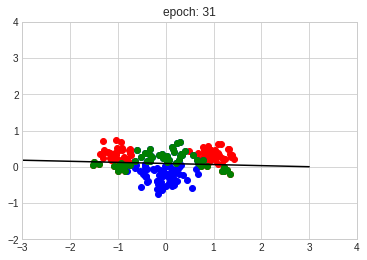

epoch:32
	batch 1/1
accuracy = 0.745, misclassified: 51

epoch:33
	batch 1/1
accuracy = 0.745, misclassified: 51

epoch:34
	batch 1/1
accuracy = 0.745, misclassified: 51

epoch:35
	batch 1/1
accuracy = 0.745, misclassified: 51

epoch:36
	batch 1/1
accuracy = 0.745, misclassified: 51

epoch:37
	batch 1/1
accuracy = 0.745, misclassified: 51

epoch:38
	batch 1/1
accuracy = 0.745, misclassified: 51

epoch:39
	batch 1/1
accuracy = 0.745, misclassified: 51

epoch:40
	batch 1/1
accuracy = 0.745, misclassified: 51

epoch:41
	batch 1/1
accuracy = 0.745, misclassified: 51



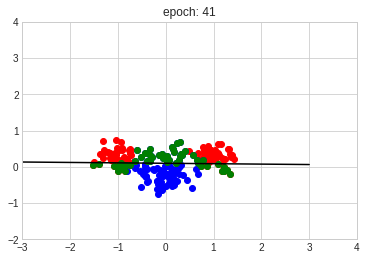

epoch:42
	batch 1/1
accuracy = 0.745, misclassified: 51

epoch:43
	batch 1/1
accuracy = 0.745, misclassified: 51

epoch:44
	batch 1/1
accuracy = 0.74, misclassified: 52

epoch:45
	batch 1/1
accuracy = 0.74, misclassified: 52

epoch:46
	batch 1/1
accuracy = 0.74, misclassified: 52

epoch:47
	batch 1/1
accuracy = 0.74, misclassified: 52

epoch:48
	batch 1/1
accuracy = 0.74, misclassified: 52

epoch:49
	batch 1/1
accuracy = 0.74, misclassified: 52

epoch:50
	batch 1/1
accuracy = 0.74, misclassified: 52



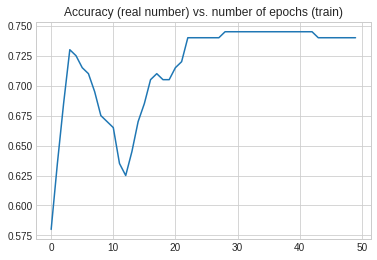

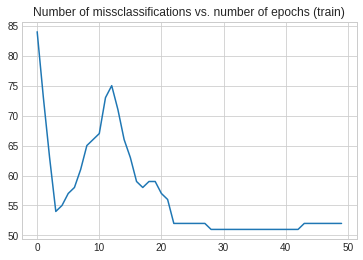

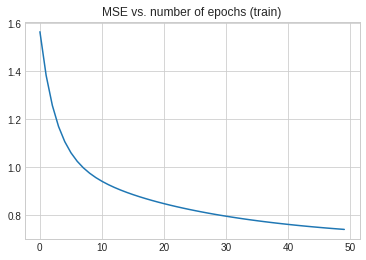

In [34]:
train_loop_1(input_data=input_data,
             targets=targets,
             classA=classA, 
             classB=classB, 
             slp=slp, 
             n_epochs=n_epochs, 
             batch_size=batch_size, 
             thresh=thresh)

Sub-sample 2: remove random 25% from each class

In [35]:
indices_plus_1 = np.argwhere(targets == 1).flatten()
subsample_indices_plus_1 = np.random.choice(indices_plus_1, int(indices_plus_1.size * 0.75))
indices_minus_1 = np.argwhere(targets == -1).flatten()
subsample_indices_minus_1 = np.random.choice(indices_minus_1, int(indices_minus_1.size * 0.75))

subsample_indices = np.concatenate((subsample_indices_plus_1, subsample_indices_minus_1))

input_data_subsampled = input_data[:, subsample_indices]
targets_subsampled = targets[subsample_indices]
classA_subsampled = classA[:, subsample_indices_plus_1]
classB_subsampled = classB[:, subsample_indices_minus_1 - indices_minus_1.size]

# Shuffle
indices_new = np.arange(targets_subsampled.shape[0])
np.random.shuffle(indices_new)
input_data_subsampled = input_data_subsampled[:,indices_new]
targets_subsampled = targets_subsampled[indices_new]

print(input_data_subsampled.shape)

(3, 150)


In [39]:
input_layer_dim = 2
learning_rate = 0.001
n_epochs = 50
# if batch_size is equal to the number of observations in the dataset,
# then we do batch_mode. if batch_mode = 1, we do stochastic optimization (these are the 2 extremes).
# in between, we do mini-batch optimization
batch_size = 150
thresh = 10e-4
#optimizer = "perceptron"
optimizer = "delta"

slp = SingleLayerPerceptron(input_layer_dim=input_layer_dim, if_bias=if_bias, learning_rate=learning_rate,
                           optimizer=optimizer)

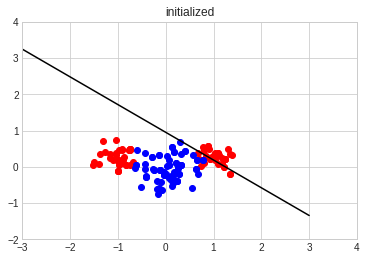

epoch:1
	batch 1/1
accuracy = 0.2866666666666667, misclassified: 107



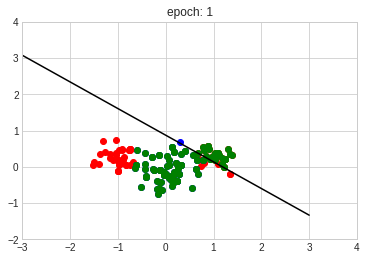

epoch:2
	batch 1/1
accuracy = 0.28, misclassified: 108

epoch:3
	batch 1/1
accuracy = 0.28, misclassified: 108

epoch:4
	batch 1/1
accuracy = 0.31333333333333335, misclassified: 103

epoch:5
	batch 1/1
accuracy = 0.29333333333333333, misclassified: 106

epoch:6
	batch 1/1
accuracy = 0.3, misclassified: 105

epoch:7
	batch 1/1
accuracy = 0.31333333333333335, misclassified: 103

epoch:8
	batch 1/1
accuracy = 0.31333333333333335, misclassified: 103

epoch:9
	batch 1/1
accuracy = 0.31333333333333335, misclassified: 103

epoch:10
	batch 1/1
accuracy = 0.3333333333333333, misclassified: 100

epoch:11
	batch 1/1
accuracy = 0.3333333333333333, misclassified: 100



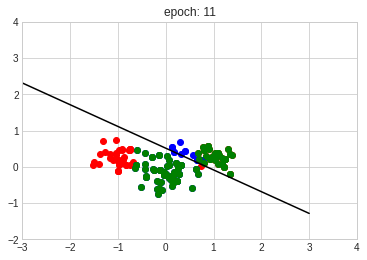

epoch:12
	batch 1/1
accuracy = 0.3333333333333333, misclassified: 100

epoch:13
	batch 1/1
accuracy = 0.3333333333333333, misclassified: 100

epoch:14
	batch 1/1
accuracy = 0.3333333333333333, misclassified: 100

epoch:15
	batch 1/1
accuracy = 0.32, misclassified: 102

epoch:16
	batch 1/1
accuracy = 0.32, misclassified: 102

epoch:17
	batch 1/1
accuracy = 0.31333333333333335, misclassified: 103

epoch:18
	batch 1/1
accuracy = 0.3, misclassified: 105

epoch:19
	batch 1/1
accuracy = 0.29333333333333333, misclassified: 106

epoch:20
	batch 1/1
accuracy = 0.2733333333333333, misclassified: 109

epoch:21
	batch 1/1
accuracy = 0.25333333333333335, misclassified: 112



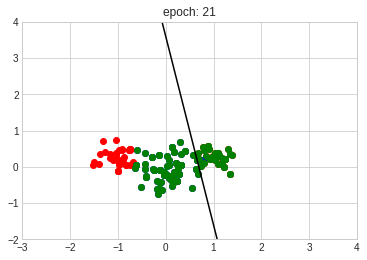

epoch:22
	batch 1/1
accuracy = 0.2866666666666667, misclassified: 107

epoch:23
	batch 1/1
accuracy = 0.32, misclassified: 102

epoch:24
	batch 1/1
accuracy = 0.4066666666666667, misclassified: 89

epoch:25
	batch 1/1
accuracy = 0.5533333333333333, misclassified: 67

epoch:26
	batch 1/1
accuracy = 0.6, misclassified: 60

epoch:27
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:28
	batch 1/1
accuracy = 0.7, misclassified: 45

epoch:29
	batch 1/1
accuracy = 0.7133333333333334, misclassified: 43

epoch:30
	batch 1/1
accuracy = 0.72, misclassified: 42

epoch:31
	batch 1/1
accuracy = 0.7066666666666667, misclassified: 44



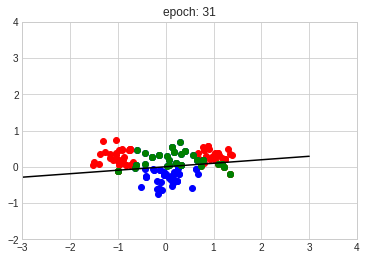

epoch:32
	batch 1/1
accuracy = 0.7066666666666667, misclassified: 44

epoch:33
	batch 1/1
accuracy = 0.7333333333333333, misclassified: 40

epoch:34
	batch 1/1
accuracy = 0.74, misclassified: 39

epoch:35
	batch 1/1
accuracy = 0.74, misclassified: 39

epoch:36
	batch 1/1
accuracy = 0.74, misclassified: 39

epoch:37
	batch 1/1
accuracy = 0.7533333333333333, misclassified: 37

epoch:38
	batch 1/1
accuracy = 0.7733333333333333, misclassified: 34

epoch:39
	batch 1/1
accuracy = 0.76, misclassified: 36

epoch:40
	batch 1/1
accuracy = 0.7533333333333333, misclassified: 37

epoch:41
	batch 1/1
accuracy = 0.7533333333333333, misclassified: 37



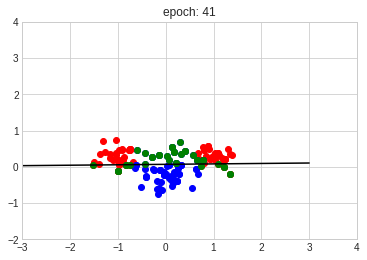

epoch:42
	batch 1/1
accuracy = 0.7466666666666667, misclassified: 38

epoch:43
	batch 1/1
accuracy = 0.7466666666666667, misclassified: 38

epoch:44
	batch 1/1
accuracy = 0.74, misclassified: 39

epoch:45
	batch 1/1
accuracy = 0.74, misclassified: 39

epoch:46
	batch 1/1
accuracy = 0.7466666666666667, misclassified: 38

epoch:47
	batch 1/1
accuracy = 0.7466666666666667, misclassified: 38

epoch:48
	batch 1/1
accuracy = 0.7466666666666667, misclassified: 38

epoch:49
	batch 1/1
accuracy = 0.7466666666666667, misclassified: 38

epoch:50
	batch 1/1
accuracy = 0.7466666666666667, misclassified: 38



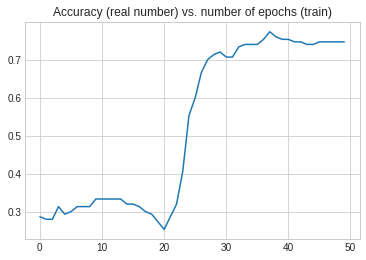

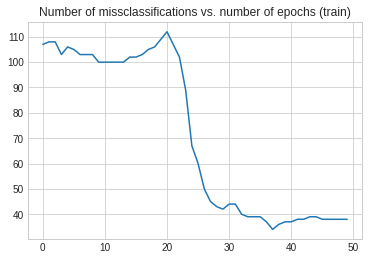

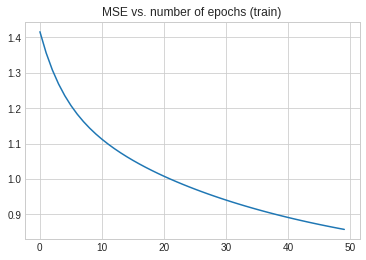

In [40]:
train_loop_1(input_data=input_data_subsampled,
             targets=targets_subsampled,
             classA=classA_subsampled, 
             classB=classB_subsampled, 
             slp=slp, 
             n_epochs=n_epochs, 
             batch_size=batch_size, 
             thresh=thresh)

Sub-sample 3: remove random 50% from classA

In [41]:
# class A is 1
indices_plus_1 = np.argwhere(targets == 1).flatten()
subsample_indices_plus_1 = np.random.choice(indices_plus_1, int(indices_plus_1.size * 0.50))
indices_minus_1 = np.argwhere(targets == -1).flatten()
subsample_indices_minus_1 = np.random.choice(indices_minus_1, int(indices_minus_1.size * 1.0))

subsample_indices = np.concatenate((subsample_indices_plus_1, subsample_indices_minus_1))

input_data_subsampled = input_data[:, subsample_indices]
targets_subsampled = targets[subsample_indices]
classA_subsampled = classA[:, subsample_indices_plus_1]
classB_subsampled = classB[:, subsample_indices_minus_1 - indices_minus_1.size]

# Shuffle
indices_new = np.arange(targets_subsampled.shape[0])
np.random.shuffle(indices_new)
input_data_subsampled = input_data_subsampled[:,indices_new]
targets_subsampled = targets_subsampled[indices_new]

print(input_data_subsampled.shape)

(3, 150)


In [42]:
input_layer_dim = 2
learning_rate = 0.001
n_epochs = 50
# if batch_size is equal to the number of observations in the dataset,
# then we do batch_mode. if batch_mode = 1, we do stochastic optimization (these are the 2 extremes).
# in between, we do mini-batch optimization
batch_size = 150
thresh = 10e-4
#optimizer = "perceptron"
optimizer = "delta"

slp = SingleLayerPerceptron(input_layer_dim=input_layer_dim, if_bias=if_bias, learning_rate=learning_rate,
                           optimizer=optimizer)

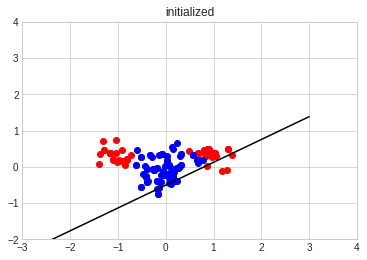

epoch:1
	batch 1/1
accuracy = 0.37333333333333335, misclassified: 94



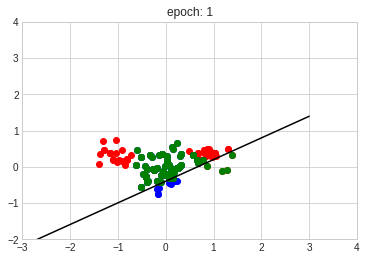

epoch:2
	batch 1/1
accuracy = 0.4266666666666667, misclassified: 86

epoch:3
	batch 1/1
accuracy = 0.4866666666666667, misclassified: 77

epoch:4
	batch 1/1
accuracy = 0.5866666666666667, misclassified: 62

epoch:5
	batch 1/1
accuracy = 0.6133333333333333, misclassified: 58

epoch:6
	batch 1/1
accuracy = 0.6466666666666666, misclassified: 53

epoch:7
	batch 1/1
accuracy = 0.6466666666666666, misclassified: 53

epoch:8
	batch 1/1
accuracy = 0.6866666666666666, misclassified: 47

epoch:9
	batch 1/1
accuracy = 0.7133333333333334, misclassified: 43

epoch:10
	batch 1/1
accuracy = 0.72, misclassified: 42

epoch:11
	batch 1/1
accuracy = 0.7266666666666667, misclassified: 41



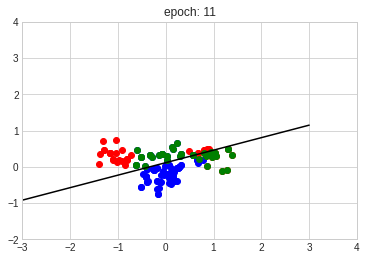

epoch:12
	batch 1/1
accuracy = 0.7466666666666667, misclassified: 38

epoch:13
	batch 1/1
accuracy = 0.7466666666666667, misclassified: 38

epoch:14
	batch 1/1
accuracy = 0.7533333333333333, misclassified: 37

epoch:15
	batch 1/1
accuracy = 0.7533333333333333, misclassified: 37

epoch:16
	batch 1/1
accuracy = 0.76, misclassified: 36

epoch:17
	batch 1/1
accuracy = 0.76, misclassified: 36

epoch:18
	batch 1/1
accuracy = 0.7733333333333333, misclassified: 34

epoch:19
	batch 1/1
accuracy = 0.7733333333333333, misclassified: 34

epoch:20
	batch 1/1
accuracy = 0.78, misclassified: 33

epoch:21
	batch 1/1
accuracy = 0.78, misclassified: 33



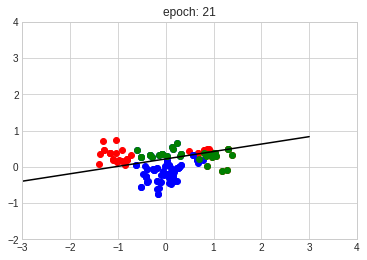

epoch:22
	batch 1/1
accuracy = 0.7933333333333333, misclassified: 31

epoch:23
	batch 1/1
accuracy = 0.7933333333333333, misclassified: 31

epoch:24
	batch 1/1
accuracy = 0.7933333333333333, misclassified: 31

epoch:25
	batch 1/1
accuracy = 0.7933333333333333, misclassified: 31

epoch:26
	batch 1/1
accuracy = 0.7933333333333333, misclassified: 31

epoch:27
	batch 1/1
accuracy = 0.8066666666666666, misclassified: 29

epoch:28
	batch 1/1
accuracy = 0.7866666666666666, misclassified: 32

epoch:29
	batch 1/1
accuracy = 0.7866666666666666, misclassified: 32

epoch:30
	batch 1/1
accuracy = 0.7866666666666666, misclassified: 32

epoch:31
	batch 1/1
accuracy = 0.7866666666666666, misclassified: 32



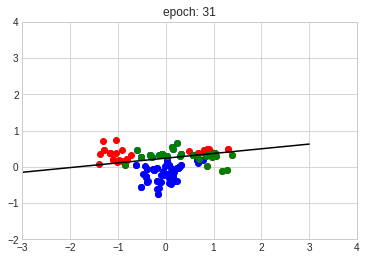

epoch:32
	batch 1/1
accuracy = 0.7933333333333333, misclassified: 31

epoch:33
	batch 1/1
accuracy = 0.7933333333333333, misclassified: 31

epoch:34
	batch 1/1
accuracy = 0.7933333333333333, misclassified: 31

epoch:35
	batch 1/1
accuracy = 0.8, misclassified: 30

epoch:36
	batch 1/1
accuracy = 0.7933333333333333, misclassified: 31

epoch:37
	batch 1/1
accuracy = 0.7933333333333333, misclassified: 31

epoch:38
	batch 1/1
accuracy = 0.7933333333333333, misclassified: 31

epoch:39
	batch 1/1
accuracy = 0.7933333333333333, misclassified: 31

epoch:40
	batch 1/1
accuracy = 0.7933333333333333, misclassified: 31

epoch:41
	batch 1/1
accuracy = 0.7933333333333333, misclassified: 31



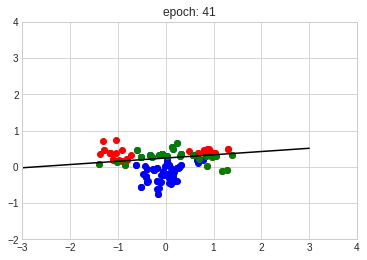

epoch:42
	batch 1/1
accuracy = 0.7933333333333333, misclassified: 31

epoch:43
	batch 1/1
accuracy = 0.7933333333333333, misclassified: 31

epoch:44
	batch 1/1
accuracy = 0.7933333333333333, misclassified: 31

epoch:45
	batch 1/1
accuracy = 0.7866666666666666, misclassified: 32

epoch:46
	batch 1/1
accuracy = 0.7866666666666666, misclassified: 32

epoch:47
	batch 1/1
accuracy = 0.78, misclassified: 33

epoch:48
	batch 1/1
accuracy = 0.78, misclassified: 33

epoch:49
	batch 1/1
accuracy = 0.78, misclassified: 33

epoch:50
	batch 1/1
accuracy = 0.7733333333333333, misclassified: 34



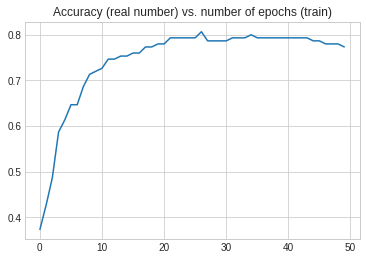

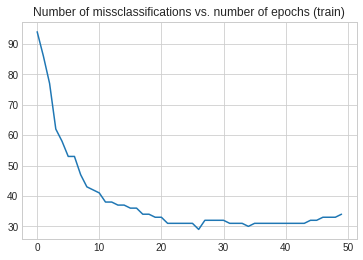

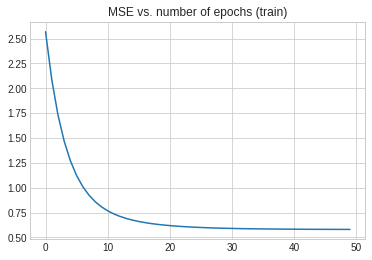

In [43]:
train_loop_1(input_data=input_data_subsampled,
             targets=targets_subsampled,
             classA=classA_subsampled, 
             classB=classB_subsampled, 
             slp=slp, 
             n_epochs=n_epochs, 
             batch_size=batch_size, 
             thresh=thresh)

Sub-sample 4: remove random 50% from classB

In [44]:
# class B is -1
indices_plus_1 = np.argwhere(targets == 1).flatten()
subsample_indices_plus_1 = np.random.choice(indices_plus_1, int(indices_plus_1.size * 1.0))
indices_minus_1 = np.argwhere(targets == -1).flatten()
subsample_indices_minus_1 = np.random.choice(indices_minus_1, int(indices_minus_1.size * 0.50))

subsample_indices = np.concatenate((subsample_indices_plus_1, subsample_indices_minus_1))

input_data_subsampled = input_data[:, subsample_indices]
targets_subsampled = targets[subsample_indices]
classA_subsampled = classA[:, subsample_indices_plus_1]
classB_subsampled = classB[:, subsample_indices_minus_1 - indices_minus_1.size]

# Shuffle
indices_new = np.arange(targets_subsampled.shape[0])
np.random.shuffle(indices_new)
input_data_subsampled = input_data_subsampled[:,indices_new]
targets_subsampled = targets_subsampled[indices_new]

print(input_data_subsampled.shape)

(3, 150)


In [45]:
input_layer_dim = 2
learning_rate = 0.001
n_epochs = 50
# if batch_size is equal to the number of observations in the dataset,
# then we do batch_mode. if batch_mode = 1, we do stochastic optimization (these are the 2 extremes).
# in between, we do mini-batch optimization
batch_size = 150
thresh = 10e-4
#optimizer = "perceptron"
optimizer = "delta"

slp = SingleLayerPerceptron(input_layer_dim=input_layer_dim, if_bias=if_bias, learning_rate=learning_rate,
                           optimizer=optimizer)

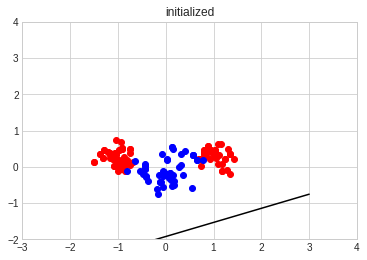

epoch:1
	batch 1/1
accuracy = 0.3333333333333333, misclassified: 100



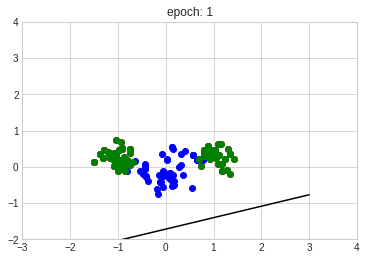

epoch:2
	batch 1/1
accuracy = 0.3333333333333333, misclassified: 100

epoch:3
	batch 1/1
accuracy = 0.3333333333333333, misclassified: 100

epoch:4
	batch 1/1
accuracy = 0.3333333333333333, misclassified: 100

epoch:5
	batch 1/1
accuracy = 0.3333333333333333, misclassified: 100

epoch:6
	batch 1/1
accuracy = 0.3333333333333333, misclassified: 100

epoch:7
	batch 1/1
accuracy = 0.32666666666666666, misclassified: 101

epoch:8
	batch 1/1
accuracy = 0.30666666666666664, misclassified: 104

epoch:9
	batch 1/1
accuracy = 0.26666666666666666, misclassified: 110

epoch:10
	batch 1/1
accuracy = 0.22666666666666666, misclassified: 116

epoch:11
	batch 1/1
accuracy = 0.2, misclassified: 120



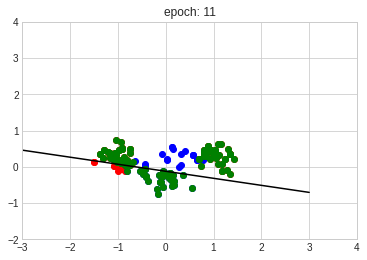

epoch:12
	batch 1/1
accuracy = 0.30666666666666664, misclassified: 104

epoch:13
	batch 1/1
accuracy = 0.4266666666666667, misclassified: 86

epoch:14
	batch 1/1
accuracy = 0.4533333333333333, misclassified: 82

epoch:15
	batch 1/1
accuracy = 0.49333333333333335, misclassified: 76

epoch:16
	batch 1/1
accuracy = 0.49333333333333335, misclassified: 76

epoch:17
	batch 1/1
accuracy = 0.4866666666666667, misclassified: 77

epoch:18
	batch 1/1
accuracy = 0.4866666666666667, misclassified: 77

epoch:19
	batch 1/1
accuracy = 0.52, misclassified: 72

epoch:20
	batch 1/1
accuracy = 0.5866666666666667, misclassified: 62

epoch:21
	batch 1/1
accuracy = 0.6266666666666667, misclassified: 56



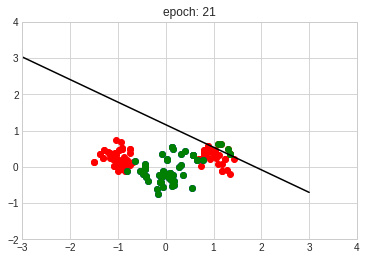

epoch:22
	batch 1/1
accuracy = 0.6466666666666666, misclassified: 53

epoch:23
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:24
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:25
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:26
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:27
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:28
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:29
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:30
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:31
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50



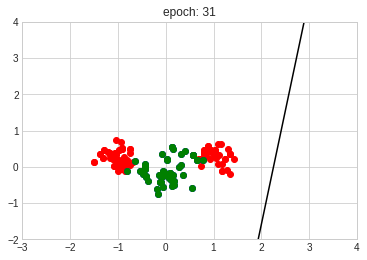

epoch:32
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:33
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:34
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:35
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:36
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:37
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:38
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:39
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:40
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:41
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50



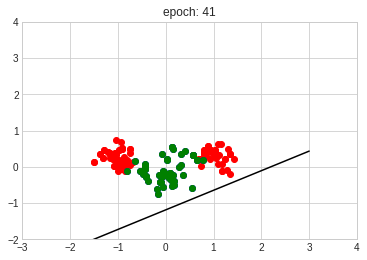

epoch:42
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:43
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:44
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:45
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:46
	batch 1/1
accuracy = 0.6666666666666666, misclassified: 50

epoch:47
	batch 1/1
accuracy = 0.6733333333333333, misclassified: 49

epoch:48
	batch 1/1
accuracy = 0.6733333333333333, misclassified: 49

epoch:49
	batch 1/1
accuracy = 0.68, misclassified: 48

epoch:50
	batch 1/1
accuracy = 0.68, misclassified: 48



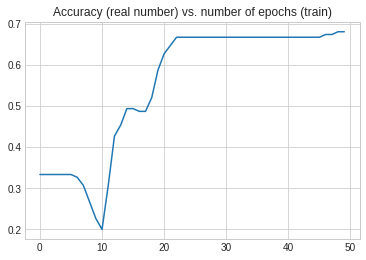

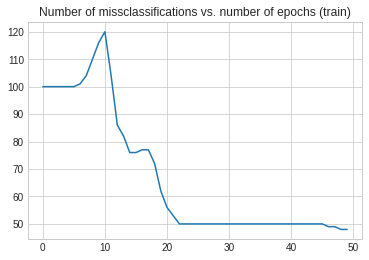

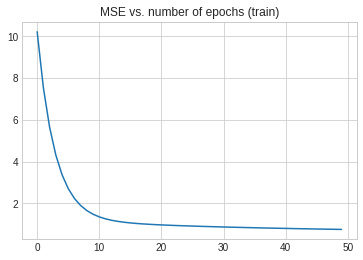

In [46]:
train_loop_1(input_data=input_data_subsampled,
             targets=targets_subsampled,
             classA=classA_subsampled, 
             classB=classB_subsampled, 
             slp=slp, 
             n_epochs=n_epochs, 
             batch_size=batch_size, 
             thresh=thresh)

Sub-sample 5: remove 20% from a subset of classA for which classA(1,:)<0 and 80% from a
subset of classA for which classA(1,:)>0

In [47]:
# class A is 1
condition_1 = np.logical_and(targets == 1, input_data[0,:] < 0)
indices_plus_1_condition_1 = np.argwhere(condition_1).flatten()
subsample_indices_plus_1_condition_1 = \
    np.random.choice(indices_plus_1_condition_1, int(indices_plus_1_condition_1.size * 0.8))

condition_2 = np.logical_and(targets == 1, 0 < input_data[0,:])
indices_plus_1_condition_2 = np.argwhere(condition_2).flatten()
subsample_indices_plus_1_condition_2 = \
    np.random.choice(indices_plus_1_condition_2, int(indices_plus_1_condition_2.size * 0.2))

subsample_indices_plus_1 = \
    np.concatenate((subsample_indices_plus_1_condition_1, subsample_indices_plus_1_condition_2))

indices_minus_1 = np.argwhere(targets == -1).flatten()
subsample_indices_minus_1 = np.random.choice(indices_minus_1, int(indices_minus_1.size * 1.0))

subsample_indices = np.concatenate((subsample_indices_plus_1, subsample_indices_minus_1))

input_data_subsampled = input_data[:, subsample_indices]
targets_subsampled = targets[subsample_indices]
classA_subsampled = classA[:, subsample_indices_plus_1]
classB_subsampled = classB[:, subsample_indices_minus_1 - indices_minus_1.size]

# Shuffle
indices_new = np.arange(targets_subsampled.shape[0])
np.random.shuffle(indices_new)
input_data_subsampled = input_data_subsampled[:,indices_new]
targets_subsampled = targets_subsampled[indices_new]

print(input_data_subsampled.shape)

(3, 150)


In [48]:
input_layer_dim = 2
learning_rate = 0.001
n_epochs = 50
# if batch_size is equal to the number of observations in the dataset,
# then we do batch_mode. if batch_mode = 1, we do stochastic optimization (these are the 2 extremes).
# in between, we do mini-batch optimization
batch_size = 150
thresh = 10e-4
#optimizer = "perceptron"
optimizer = "delta"

slp = SingleLayerPerceptron(input_layer_dim=input_layer_dim, if_bias=if_bias, learning_rate=learning_rate,
                           optimizer=optimizer)

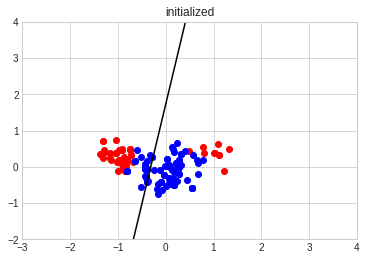

epoch:1
	batch 1/1
accuracy = 0.8, misclassified: 30



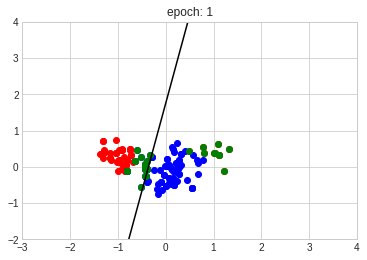

epoch:2
	batch 1/1
accuracy = 0.8466666666666667, misclassified: 23

epoch:3
	batch 1/1
accuracy = 0.8666666666666667, misclassified: 20

epoch:4
	batch 1/1
accuracy = 0.8866666666666667, misclassified: 17

epoch:5
	batch 1/1
accuracy = 0.8866666666666667, misclassified: 17

epoch:6
	batch 1/1
accuracy = 0.8866666666666667, misclassified: 17

epoch:7
	batch 1/1
accuracy = 0.8866666666666667, misclassified: 17

epoch:8
	batch 1/1
accuracy = 0.8866666666666667, misclassified: 17

epoch:9
	batch 1/1
accuracy = 0.8866666666666667, misclassified: 17

epoch:10
	batch 1/1
accuracy = 0.8866666666666667, misclassified: 17

epoch:11
	batch 1/1
accuracy = 0.8866666666666667, misclassified: 17



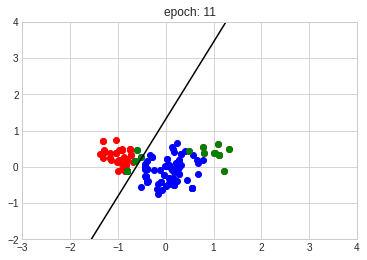

epoch:12
	batch 1/1
accuracy = 0.8866666666666667, misclassified: 17

epoch:13
	batch 1/1
accuracy = 0.8866666666666667, misclassified: 17

epoch:14
	batch 1/1
accuracy = 0.8866666666666667, misclassified: 17

epoch:15
	batch 1/1
accuracy = 0.8866666666666667, misclassified: 17

epoch:16
	batch 1/1
accuracy = 0.8866666666666667, misclassified: 17

epoch:17
	batch 1/1
accuracy = 0.8866666666666667, misclassified: 17

epoch:18
	batch 1/1
accuracy = 0.8866666666666667, misclassified: 17

epoch:19
	batch 1/1
accuracy = 0.8866666666666667, misclassified: 17

epoch:20
	batch 1/1
accuracy = 0.8866666666666667, misclassified: 17

epoch:21
	batch 1/1
accuracy = 0.8866666666666667, misclassified: 17



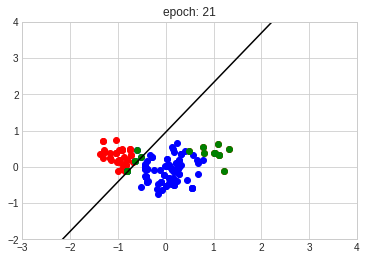

epoch:22
	batch 1/1
accuracy = 0.8866666666666667, misclassified: 17

epoch:23
	batch 1/1
accuracy = 0.9066666666666666, misclassified: 14

epoch:24
	batch 1/1
accuracy = 0.9066666666666666, misclassified: 14

epoch:25
	batch 1/1
accuracy = 0.9066666666666666, misclassified: 14

epoch:26
	batch 1/1
accuracy = 0.9066666666666666, misclassified: 14

epoch:27
	batch 1/1
accuracy = 0.9066666666666666, misclassified: 14

epoch:28
	batch 1/1
accuracy = 0.9066666666666666, misclassified: 14

epoch:29
	batch 1/1
accuracy = 0.9066666666666666, misclassified: 14

epoch:30
	batch 1/1
accuracy = 0.9066666666666666, misclassified: 14

epoch:31
	batch 1/1
accuracy = 0.8933333333333333, misclassified: 16



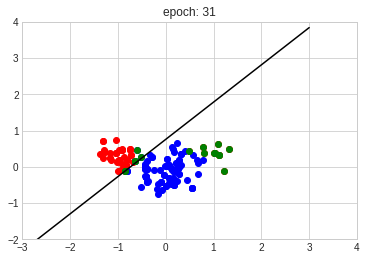

epoch:32
	batch 1/1
accuracy = 0.8933333333333333, misclassified: 16

epoch:33
	batch 1/1
accuracy = 0.8933333333333333, misclassified: 16

epoch:34
	batch 1/1
accuracy = 0.8933333333333333, misclassified: 16

epoch:35
	batch 1/1
accuracy = 0.8933333333333333, misclassified: 16

epoch:36
	batch 1/1
accuracy = 0.8933333333333333, misclassified: 16

epoch:37
	batch 1/1
accuracy = 0.8933333333333333, misclassified: 16

epoch:38
	batch 1/1
accuracy = 0.8933333333333333, misclassified: 16

epoch:39
	batch 1/1
accuracy = 0.8933333333333333, misclassified: 16

epoch:40
	batch 1/1
accuracy = 0.8933333333333333, misclassified: 16

epoch:41
	batch 1/1
accuracy = 0.8933333333333333, misclassified: 16



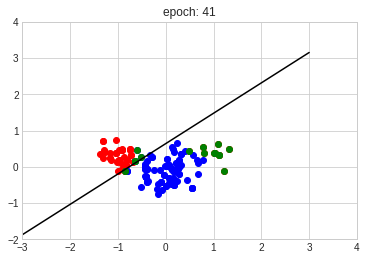

epoch:42
	batch 1/1
accuracy = 0.8933333333333333, misclassified: 16

epoch:43
	batch 1/1
accuracy = 0.8933333333333333, misclassified: 16

epoch:44
	batch 1/1
accuracy = 0.8933333333333333, misclassified: 16

epoch:45
	batch 1/1
accuracy = 0.8933333333333333, misclassified: 16

epoch:46
	batch 1/1
accuracy = 0.8933333333333333, misclassified: 16

epoch:47
	batch 1/1
accuracy = 0.8933333333333333, misclassified: 16

epoch:48
	batch 1/1
accuracy = 0.8933333333333333, misclassified: 16

epoch:49
	batch 1/1
accuracy = 0.8933333333333333, misclassified: 16

epoch:50
	batch 1/1
accuracy = 0.8866666666666667, misclassified: 17



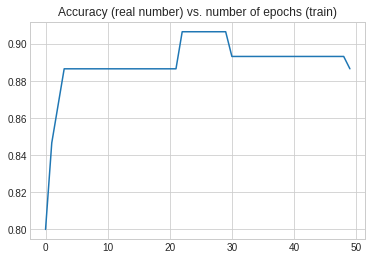

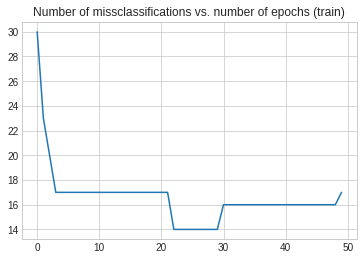

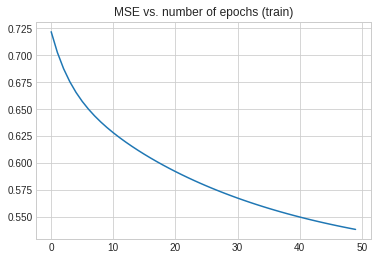

In [49]:
train_loop_1(input_data=input_data_subsampled,
             targets=targets_subsampled,
             classA=classA_subsampled, 
             classB=classB_subsampled, 
             slp=slp, 
             n_epochs=n_epochs, 
             batch_size=batch_size, 
             thresh=thresh)

## 3.2 Classification and regression with a two-layer perceptron

### 3.2.1 Classification of linearly non-separable data

This is basically what Patrick did in the .py script just in object-oriented implementation, similar to SLP above.

In [50]:
class MultiLayerPerceptron():
    """ MLP.
    """
    def __init__(self, input_layer_dim, hidden_layer_dim, learning_rate, non_linearity, optimizer, **kwargs):
        """ Init.
        
        Parameters
        ----------
        input_layer_dim : int
            No. of nodes in input layer (without bias).
        hidden_layer_dim : int
            No. of nodes in hidden layer (without bias).
        learning_rate : float
            Learning rate.
        non_linearity : str
            Type of non-linearity. check tanh = {-1,1} but sigmoid={0,1}
        optimizer : str
            Type of optimizer.
        kwargs : dict
            If optimizer is sgd_momentum, then include beta.

        Returns
        -----------
        None
        """
        self.input_layer_dim = input_layer_dim
        self.hidden_layer_dim = hidden_layer_dim
        self.learning_rate = learning_rate
        assert non_linearity in ["sigmoid", "tanh"], \
            f"non_linearity has to be either sigmoid or tanh, got {non_linearity}"
        self.non_linearity = non_linearity
        
        self.w = np.random.normal(loc=0, scale=1, size=(self.hidden_layer_dim, self.input_layer_dim + 1))
        self.v = np.random.normal(loc=0, scale=1, size=(1, self.hidden_layer_dim + 1))
        
        assert optimizer in ["sgd", "sgd_momentum"], \
            f"optimizer has to be etiher sgd or sgd_momentum, got {optimizer}"
        self.optimizer = optimizer
        if self.optimizer == "sgd_momentum":
            try:
                beta = kwargs["beta"]
            except Exception:
                raise Exception("sgd_momentum needs beta in kwargs")
            else:
                self.beta = beta
                self.dw_old = np.zeros(self.w.shape)
                self.dv_old = np.zeros(self.v.shape)
    
    def non_linearity_forward(self, signal_sum):
        """ Non-linearity / activation function.
        
        Parameters
        ----------
        signal_sum : np.ndarray
            Of shape (current_layer_dim, n_data)

        Returns
        -----------
        activation : np.ndarray
            Of shape (current_layer_dim, n_data)
        """
        if self.non_linearity == "sigmoid":
            activation = 1 / (1 + np.exp(-signal_sum))
        else:
            activation = np.tanh(signal_sum)
        return activation
    
    def forward_pass(self, inputs):
        """ Forward-pass.
        
        Parameters
        ----------
        inputs : np.ndarray
            Of shape (input_layer_dim + 1, n_data)

        Returns
        -----------
        out : np.ndarray
            Of shape (1, n_data)
        oin : np.ndarray
            Of shape (1, n_data)
        hout : np.ndarray
            Of shape (hidden_layer_dim + 1, n_data)
        hin : np.ndarray
            Of shape (hidden_layer_dim, n_data)
        """
        hin = np.dot(self.w, inputs)
        hout_minus_bias = self.non_linearity_forward(hin)
        hout = np.concatenate((hout_minus_bias, 
                                np.ones((1, hout_minus_bias.shape[1]))), axis=0)
        oin = np.dot(self.v, hout)
        out = self.non_linearity_forward(oin)
        
        return out, oin, hout, hin
    
    def non_linearity_backward(self, activation):
        """ Derivative of non-linearity.
        
        Parameters
        ----------
        activation : np.ndarray
            Of shape (current_layer_dim, n_data)

        Returns
        -----------
        d_activation : np.ndarray
            Of shape (current_layer_dim, n_data)
        """
        if self.non_linearity == "sigmoid":
            d_activation = np.multiply(activation, 1 - activation)
        else:
            d_activation = 1 - np.power(activation, 2)
        
        return d_activation
    
    def backward_pass(self, out, oin, hout, hin, targets):
        """ Backward-pass.
        
        Parameters
        ----------
        out : np.ndarray
            Of shape (1, n_data)
        oin : np.ndarray
            Of shape (1, n_data)
        hout : np.ndarray
            Of shape (hidden_layer_dim + 1, n_data)
        hin : np.ndarray
            Of shape (hidden_layer_dim, n_data)
        targets : np.ndarray
            Of shape (n_data,)

        Returns
        -----------
        delta_o : np.ndarray
            Of shape (1, n_data)
        delta_h : np.ndarray
            Of shape (hidden_layer_dim, n_data)
        """
        targets = targets.reshape(1, -1)
        
        delta_o = np.multiply(out - targets, self.non_linearity_backward(out))
        delta_h = \
            np.multiply(np.dot(self.v.transpose(), delta_o), self.non_linearity_backward(hout))
        delta_h = delta_h[:self.hidden_layer_dim, :]
        
        return delta_o, delta_h
    
    def update_weights(self, inputs, hout, delta_o, delta_h):
        """ Weight update rule.
        
        Parameters
        ----------
        inputs : np.ndarray
            Of shape (input_layer_dim + 1, n_data)
        hout : np.ndarray
            Of shape (hidden_layer_dim + 1, n_data)
        delta_o : np.ndarray
            Of shape (1, n_data)
        delta_h : np.ndarray
            Of shape (hidden_layer_dim, n_data)

        Returns
        -----------
        None
        """
        if self.optimizer == "sgd":
            dw = - self.learning_rate * np.dot(delta_h, inputs.transpose())
            dv = - self.learning_rate * np.dot(delta_o, hout.transpose())
        else:
            dw = - self.learning_rate * \
                self.beta * self.dw_old - (1 - self.beta) * np.dot(delta_h, inputs.transpose())
            self.dw_old = dw
            dv = - self.learning_rate * \
                self.beta * self.dv_old - (1 - self.beta) * np.dot(delta_o, hout.transpose())
            self.dv_old = dv
        
        self.w += dw
        self.v += dv
    
    def __repr__(self):
        """ Print MLP.
        Parameters
        ----------
        None

        Returns
        -----------
        str
            The representation of the MLP as a string.
        """
        input_layer = f"input_layer: {self.w.shape}"
        hidden_layer = f"input_layer: {self.v.shape}"
        return input_layer + "\n" + hidden_layer + "\n" + self.optimizer + "\n" + self.non_linearity
        

In [51]:
def plot_dec_boundary_mlp(mlp, inputs, targets):
    """ Plot decision boundary of MLP.
    source: 
    https://hackernoon.com/how-to-plot-a-decision-boundary-for-machine-learning-algorithms-in-python-3o1n3w07
    
    Parameters
    ----------
    mlp : MultiLayerPerceptron
        MLP.
    inputs : np.ndarray
            Of shape (input_layer_dim + 1, n_data)
    targets : np.ndarray
        Of shape (n_data,)
    
    Returns
    -----------
    None
    """
    # transform for subsequent stuff. see source.
    X = inputs[:2, :].transpose()
    # define bounds of the domain
    min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
    min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.3)
    x2grid = np.arange(min2, max2, 0.3)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # transform as in source.
    grid_old = grid.copy()
    grid = grid.transpose()
    grid = np.concatenate((grid, np.ones((1, grid.shape[1]))), axis=0)
    # predict
    out, oin, hout, hin = mlp.forward_pass(inputs=grid)
    # transform as in source.
    out = out.flatten()
    # assign to comply with source.
    yhat = out
    y = targets.copy()
    grid = grid_old.copy()
    
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='Paired')
    
    c = plt.contourf(xx, yy, zz, cmap='RdBu')
    # add a legend, called a color bar
    plt.colorbar(c)
    
    # create scatter plot for samples from each class
    for class_value in np.unique(targets):
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')
    plt.show()

In [52]:
def partition_train_val(input_data, targets, test_size, if_stratify=True):
    input_data = input_data.transpose()
    if if_stratify:
        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=0)
    else:
        sss = ShuffleSplit(n_splits=1, test_size=test_size, random_state=0)
    
    sss.get_n_splits(input_data, targets)
    
    for train_index, test_index in sss.split(input_data, targets):
        #print("TRAIN:", train_index, "TEST:", test_index)
        input_data_train, input_data_val = input_data[train_index], input_data[test_index]
        targets_train, targets_val = targets[train_index], targets[test_index]
        
    input_data_train = input_data_train.transpose()
    input_data_val = input_data_val.transpose()
    print(input_data_train.shape)
    print(input_data_val.shape)
    
    return input_data_train, targets_train, input_data_val, targets_val

In [53]:
def compute_metrics_mlp(mlp, input_data, targets):
    
    out, oin, hout, hin = mlp.forward_pass(inputs=input_data)
    err = targets - out
    mse = np.mean(np.square(err))
    out = out.flatten()
    #print(out)
    
    if mlp.non_linearity == "sigmoid":
        thresh = 0.5
        out[out <= thresh] = 0
        out[thresh < out] = 1
    else:
        thresh = 0
        out[out <= thresh] = -1
        out[thresh < out] = 1
    
    accuracy = np.sum(out == targets) / targets.shape[0]
    misclassification = np.argwhere(out != targets).size
    
    return accuracy, misclassification, mse

In [54]:
def plot_mlp_accuracy_vs_n_epohcs(accuracies_train, accuracies_val=None):
    """ Plots accuracy vs epochs.

    Parameters
    ----------
    accuracies_train : list
        List of accuracies over epochs.
    accuracies_val : list
        List of accuracies over epochs.
    
    Returns
    -----------
    None
    """
    plt.plot(accuracies_train, color="blue", label="train")
    if accuracies_val is not None:
        plt.plot(accuracies_val, color="red", label="val")
    plt.title("Accuracy (real number) vs. number of epochs")
    plt.legend(loc="upper right")
    plt.show()
    
def plot_mlp_misclassification_vs_n_epohcs(misclassifications_train, misclassifications_val=None):
    """ Plots number of misclassifications vs epochs.

    Parameters
    ----------
    misclassifications : list
        List of number of misclassifications over epochs.
    misclassifications_val : list
        List of number of misclassifications over epochs.
    Returns
    -----------
    None
    """
    plt.plot(misclassifications_train, color="blue", label="train")
    if misclassifications_val is not None:
        plt.plot(misclassifications_val, color="red", label="val")
    plt.title("Rate of missclassifications vs. number of epochs")
    plt.legend(loc="upper right")
    plt.show()
    
def plot_mlp_mse_vs_n_epochs(mses_train, mses_val=None):
    """ Plots MSE vs epochs. Only makes real sense for delta learning. Just ignore
    for perceptron learning.

    Parameters
    ----------
    mses_train : list
        List of MSE values over epochs.
    mses_val : list
        List of MSE values over epochs.
    
    Returns
    -----------
    None
    """
    plt.plot(mses_train, color="blue", label="train")
    if mses_val is not None:
        plt.plot(mses_val, color="red", label="val")
    plt.title("MSE vs. number of epochs")
    plt.legend(loc="upper right")
    plt.show()

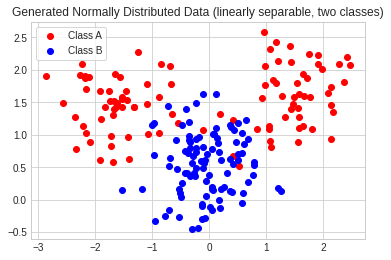

(200,)


In [55]:
n = 100
mA = [1.5, 1.5]
mB = [0, 0.5]
sigmaA = sigmaB = 0.5
dim = 2
# also used in perceptron instantiation
if_bias = True
input_data, targets, classA, classB = generate_data_2(n, mA, mB, sigmaA, sigmaB, dim, if_bias)
print(targets.shape)

Train MLP. can do mini-bacth (sequential), no val set.

input_layer: (3, 3)
input_layer: (1, 4)
sgd_momentum
sigmoid
epoch:1
	batch 1/1


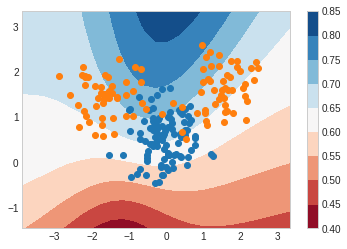

epoch:2
	batch 1/1
epoch:3
	batch 1/1
epoch:4
	batch 1/1
epoch:5
	batch 1/1
epoch:6
	batch 1/1
epoch:7
	batch 1/1
epoch:8
	batch 1/1
epoch:9
	batch 1/1
epoch:10
	batch 1/1
epoch:11
	batch 1/1


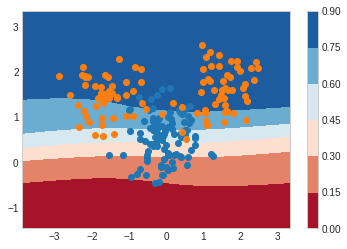

epoch:12
	batch 1/1
epoch:13
	batch 1/1
epoch:14
	batch 1/1
epoch:15
	batch 1/1
epoch:16
	batch 1/1
epoch:17
	batch 1/1
epoch:18
	batch 1/1
epoch:19
	batch 1/1
epoch:20
	batch 1/1
epoch:21
	batch 1/1


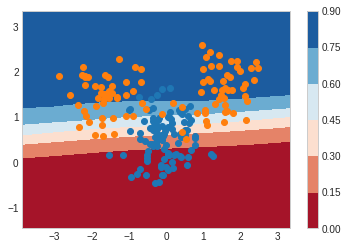

epoch:22
	batch 1/1
epoch:23
	batch 1/1
epoch:24
	batch 1/1
epoch:25
	batch 1/1
epoch:26
	batch 1/1
epoch:27
	batch 1/1
epoch:28
	batch 1/1
epoch:29
	batch 1/1
epoch:30
	batch 1/1
epoch:31
	batch 1/1


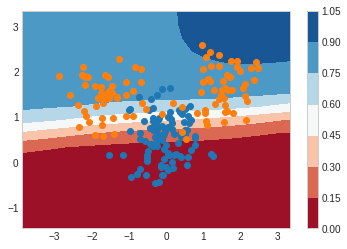

epoch:32
	batch 1/1
epoch:33
	batch 1/1
epoch:34
	batch 1/1
epoch:35
	batch 1/1
epoch:36
	batch 1/1
epoch:37
	batch 1/1
epoch:38
	batch 1/1
epoch:39
	batch 1/1
epoch:40
	batch 1/1
epoch:41
	batch 1/1


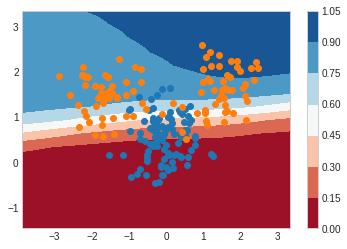

epoch:42
	batch 1/1
epoch:43
	batch 1/1
epoch:44
	batch 1/1
epoch:45
	batch 1/1
epoch:46
	batch 1/1
epoch:47
	batch 1/1
epoch:48
	batch 1/1
epoch:49
	batch 1/1
epoch:50
	batch 1/1
epoch:51
	batch 1/1


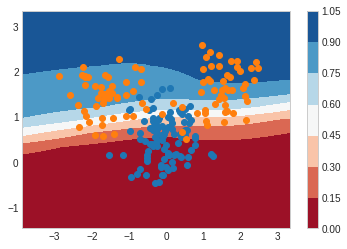

epoch:52
	batch 1/1
epoch:53
	batch 1/1
epoch:54
	batch 1/1
epoch:55
	batch 1/1
epoch:56
	batch 1/1
epoch:57
	batch 1/1
epoch:58
	batch 1/1
epoch:59
	batch 1/1
epoch:60
	batch 1/1
epoch:61
	batch 1/1


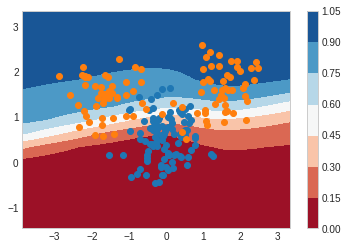

epoch:62
	batch 1/1
epoch:63
	batch 1/1
epoch:64
	batch 1/1
epoch:65
	batch 1/1
epoch:66
	batch 1/1
epoch:67
	batch 1/1
epoch:68
	batch 1/1
epoch:69
	batch 1/1
epoch:70
	batch 1/1
epoch:71
	batch 1/1


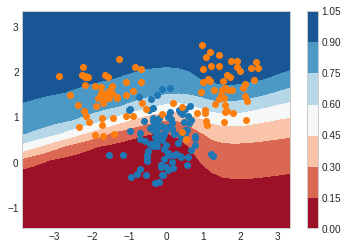

epoch:72
	batch 1/1
epoch:73
	batch 1/1
epoch:74
	batch 1/1
epoch:75
	batch 1/1
epoch:76
	batch 1/1
epoch:77
	batch 1/1
epoch:78
	batch 1/1
epoch:79
	batch 1/1
epoch:80
	batch 1/1
epoch:81
	batch 1/1


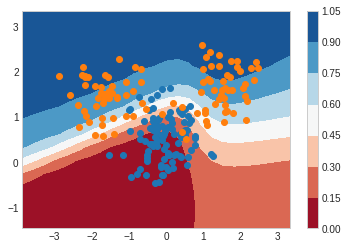

epoch:82
	batch 1/1
epoch:83
	batch 1/1
epoch:84
	batch 1/1
epoch:85
	batch 1/1
epoch:86
	batch 1/1
epoch:87
	batch 1/1
epoch:88
	batch 1/1
epoch:89
	batch 1/1
epoch:90
	batch 1/1
epoch:91
	batch 1/1


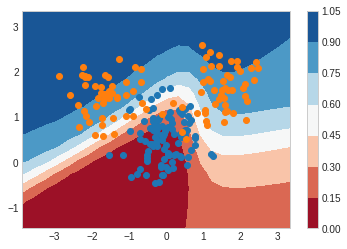

epoch:92
	batch 1/1
epoch:93
	batch 1/1
epoch:94
	batch 1/1
epoch:95
	batch 1/1
epoch:96
	batch 1/1
epoch:97
	batch 1/1
epoch:98
	batch 1/1
epoch:99
	batch 1/1
epoch:100
	batch 1/1


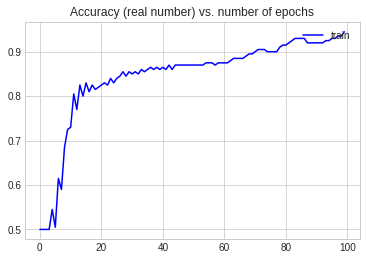

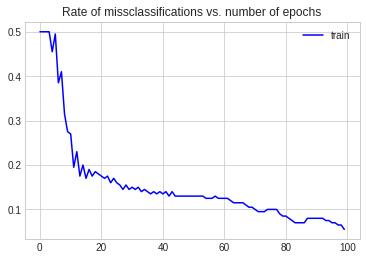

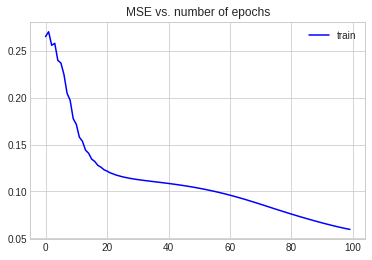

In [56]:
"""#combo 1. depends on weight init, may get stuck in local minima
input_layer_dim = dim
hidden_layer_dim = 20
learning_rate = 0.1
non_linearity = "tanh"
#optimizer = "sgd"
kwargs = {}
optimizer, kwargs["beta"] = "sgd_momentum", 0.9
epochs = 100"""

"""#combo 1.2. depends on weight init, may get stuck in local minima
input_layer_dim = dim
hidden_layer_dim = 3
learning_rate = 0.01
non_linearity = "tanh"
optimizer = "sgd"
kwargs = {}
#optimizer, kwargs["beta"] = "sgd_momentum", 0.9
epochs = 100"""

#combo 2. depends on weight init, may get stuck in local minima
input_layer_dim = dim
hidden_layer_dim = 3
learning_rate = 0.001
non_linearity = "sigmoid"
#optimizer = "sgd"
kwargs = {}
optimizer, kwargs["beta"] = "sgd_momentum", 0.9
epochs = 100

"""#combo 2.1. depends on weight init, may get stuck in local minima
input_layer_dim = dim
hidden_layer_dim = 10
learning_rate = 0.1
non_linearity = "sigmoid"
optimizer = "sgd"
kwargs = {}
#optimizer, kwargs["beta"] = "sgd_momentum", 0.9
epochs = 100"""


mlp = MultiLayerPerceptron(input_layer_dim, hidden_layer_dim, learning_rate, 
                           non_linearity, optimizer, **kwargs)
print(mlp)

batch_size = 200

mses = []
misclassifications = []
accuracies = []

targets_adjusted = targets.copy()

if non_linearity == "sigmoid":
    targets_adjusted[targets_adjusted == -1] = 0

for i in range(epochs):
    
    # Assert that batch_size is okay
    assert input_data.shape[1] % batch_size == 0, \
        f"n_data is {input_data.shape[1]}, has to be divisible by batch_size = {batch_size}"
    n_batch = int(input_data.shape[1] / batch_size)

    # Iterate over mini-batches (if batch_size is the number of observations in the dataset, then 
    # it is batch mode, if batch_size = 1 then stochastic mode)
    print(f"epoch:{i+1}")

    for b in range(n_batch):
        input_data_batch = input_data[:, b*batch_size:(b+1)*batch_size]
        targets_batch = targets_adjusted[b*batch_size:(b+1)*batch_size]
    
        out, oin, hout, hin = mlp.forward_pass(inputs=input_data_batch)
        delta_o, delta_h = mlp.backward_pass(out, oin, hout, hin, targets_batch)
        mlp.update_weights(input_data_batch, hout, delta_o, delta_h)
        
        print(f"\tbatch {b+1}/{n_batch}")
    
    accuracy, misclassification, mse = compute_metrics_mlp(mlp, input_data, targets_adjusted)
    mses.append(mse)
    misclassifications.append(misclassification)
    accuracies.append(accuracy)
    
    if i % 10 == 0:
        plot_dec_boundary_mlp(mlp, input_data, targets_adjusted)
    
plot_mlp_accuracy_vs_n_epohcs(accuracies)
misclassifications_rate = np.array(misclassifications) / input_data.shape[1]
plot_mlp_misclassification_vs_n_epohcs(misclassifications_rate)
plot_mlp_mse_vs_n_epochs(mses)

Train MLP. can do mini-bacth (sequential), USES val set.

input_layer: (3, 3)
input_layer: (1, 4)
sgd_momentum
sigmoid
(3, 150)
(3, 50)
epoch:1
	batch 1/3
	batch 2/3
	batch 3/3


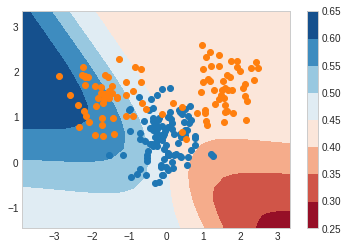

epoch:2
	batch 1/3
	batch 2/3
	batch 3/3
epoch:3
	batch 1/3
	batch 2/3
	batch 3/3
epoch:4
	batch 1/3
	batch 2/3
	batch 3/3
epoch:5
	batch 1/3
	batch 2/3
	batch 3/3
epoch:6
	batch 1/3
	batch 2/3
	batch 3/3
epoch:7
	batch 1/3
	batch 2/3
	batch 3/3
epoch:8
	batch 1/3
	batch 2/3
	batch 3/3
epoch:9
	batch 1/3
	batch 2/3
	batch 3/3
epoch:10
	batch 1/3
	batch 2/3
	batch 3/3
epoch:11
	batch 1/3
	batch 2/3
	batch 3/3


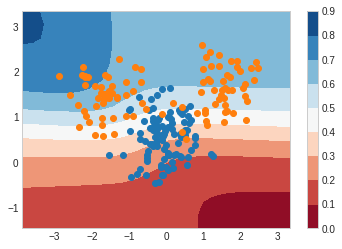

epoch:12
	batch 1/3
	batch 2/3
	batch 3/3
epoch:13
	batch 1/3
	batch 2/3
	batch 3/3
epoch:14
	batch 1/3
	batch 2/3
	batch 3/3
epoch:15
	batch 1/3
	batch 2/3
	batch 3/3
epoch:16
	batch 1/3
	batch 2/3
	batch 3/3
epoch:17
	batch 1/3
	batch 2/3
	batch 3/3
epoch:18
	batch 1/3
	batch 2/3
	batch 3/3
epoch:19
	batch 1/3
	batch 2/3
	batch 3/3
epoch:20
	batch 1/3
	batch 2/3
	batch 3/3
epoch:21
	batch 1/3
	batch 2/3
	batch 3/3


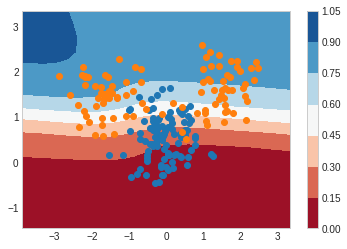

epoch:22
	batch 1/3
	batch 2/3
	batch 3/3
epoch:23
	batch 1/3
	batch 2/3
	batch 3/3
epoch:24
	batch 1/3
	batch 2/3
	batch 3/3
epoch:25
	batch 1/3
	batch 2/3
	batch 3/3
epoch:26
	batch 1/3
	batch 2/3
	batch 3/3
epoch:27
	batch 1/3
	batch 2/3
	batch 3/3
epoch:28
	batch 1/3
	batch 2/3
	batch 3/3
epoch:29
	batch 1/3
	batch 2/3
	batch 3/3
epoch:30
	batch 1/3
	batch 2/3
	batch 3/3
epoch:31
	batch 1/3
	batch 2/3
	batch 3/3


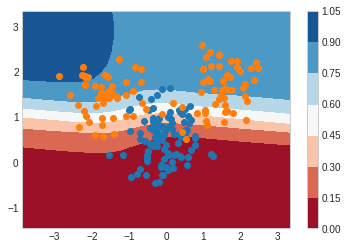

epoch:32
	batch 1/3
	batch 2/3
	batch 3/3
epoch:33
	batch 1/3
	batch 2/3
	batch 3/3
epoch:34
	batch 1/3
	batch 2/3
	batch 3/3
epoch:35
	batch 1/3
	batch 2/3
	batch 3/3
epoch:36
	batch 1/3
	batch 2/3
	batch 3/3
epoch:37
	batch 1/3
	batch 2/3
	batch 3/3
epoch:38
	batch 1/3
	batch 2/3
	batch 3/3
epoch:39
	batch 1/3
	batch 2/3
	batch 3/3
epoch:40
	batch 1/3
	batch 2/3
	batch 3/3
epoch:41
	batch 1/3
	batch 2/3
	batch 3/3


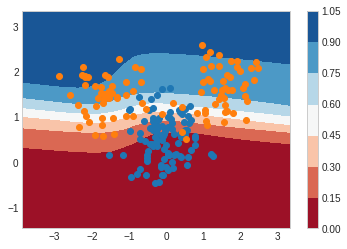

epoch:42
	batch 1/3
	batch 2/3
	batch 3/3
epoch:43
	batch 1/3
	batch 2/3
	batch 3/3
epoch:44
	batch 1/3
	batch 2/3
	batch 3/3
epoch:45
	batch 1/3
	batch 2/3
	batch 3/3
epoch:46
	batch 1/3
	batch 2/3
	batch 3/3
epoch:47
	batch 1/3
	batch 2/3
	batch 3/3
epoch:48
	batch 1/3
	batch 2/3
	batch 3/3
epoch:49
	batch 1/3
	batch 2/3
	batch 3/3
epoch:50
	batch 1/3
	batch 2/3
	batch 3/3
epoch:51
	batch 1/3
	batch 2/3
	batch 3/3


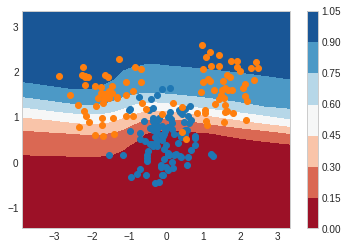

epoch:52
	batch 1/3
	batch 2/3
	batch 3/3
epoch:53
	batch 1/3
	batch 2/3
	batch 3/3
epoch:54
	batch 1/3
	batch 2/3
	batch 3/3
epoch:55
	batch 1/3
	batch 2/3
	batch 3/3
epoch:56
	batch 1/3
	batch 2/3
	batch 3/3
epoch:57
	batch 1/3
	batch 2/3
	batch 3/3
epoch:58
	batch 1/3
	batch 2/3
	batch 3/3
epoch:59
	batch 1/3
	batch 2/3
	batch 3/3
epoch:60
	batch 1/3
	batch 2/3
	batch 3/3
epoch:61
	batch 1/3
	batch 2/3
	batch 3/3


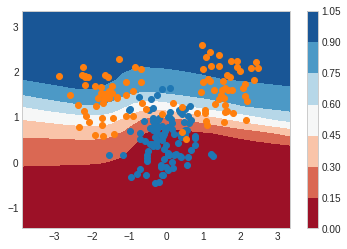

epoch:62
	batch 1/3
	batch 2/3
	batch 3/3
epoch:63
	batch 1/3
	batch 2/3
	batch 3/3
epoch:64
	batch 1/3
	batch 2/3
	batch 3/3
epoch:65
	batch 1/3
	batch 2/3
	batch 3/3
epoch:66
	batch 1/3
	batch 2/3
	batch 3/3
epoch:67
	batch 1/3
	batch 2/3
	batch 3/3
epoch:68
	batch 1/3
	batch 2/3
	batch 3/3
epoch:69
	batch 1/3
	batch 2/3
	batch 3/3
epoch:70
	batch 1/3
	batch 2/3
	batch 3/3
epoch:71
	batch 1/3
	batch 2/3
	batch 3/3


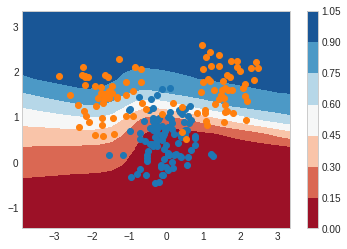

epoch:72
	batch 1/3
	batch 2/3
	batch 3/3
epoch:73
	batch 1/3
	batch 2/3
	batch 3/3
epoch:74
	batch 1/3
	batch 2/3
	batch 3/3
epoch:75
	batch 1/3
	batch 2/3
	batch 3/3
epoch:76
	batch 1/3
	batch 2/3
	batch 3/3
epoch:77
	batch 1/3
	batch 2/3
	batch 3/3
epoch:78
	batch 1/3
	batch 2/3
	batch 3/3
epoch:79
	batch 1/3
	batch 2/3
	batch 3/3
epoch:80
	batch 1/3
	batch 2/3
	batch 3/3
epoch:81
	batch 1/3
	batch 2/3
	batch 3/3


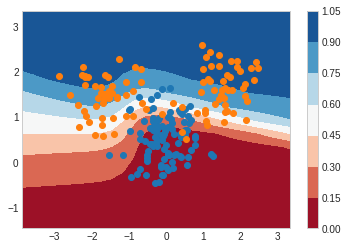

epoch:82
	batch 1/3
	batch 2/3
	batch 3/3
epoch:83
	batch 1/3
	batch 2/3
	batch 3/3
epoch:84
	batch 1/3
	batch 2/3
	batch 3/3
epoch:85
	batch 1/3
	batch 2/3
	batch 3/3
epoch:86
	batch 1/3
	batch 2/3
	batch 3/3
epoch:87
	batch 1/3
	batch 2/3
	batch 3/3
epoch:88
	batch 1/3
	batch 2/3
	batch 3/3
epoch:89
	batch 1/3
	batch 2/3
	batch 3/3
epoch:90
	batch 1/3
	batch 2/3
	batch 3/3
epoch:91
	batch 1/3
	batch 2/3
	batch 3/3


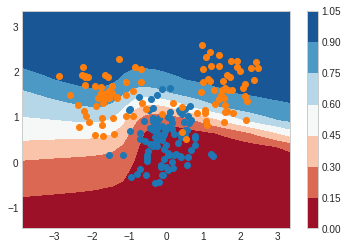

epoch:92
	batch 1/3
	batch 2/3
	batch 3/3
epoch:93
	batch 1/3
	batch 2/3
	batch 3/3
epoch:94
	batch 1/3
	batch 2/3
	batch 3/3
epoch:95
	batch 1/3
	batch 2/3
	batch 3/3
epoch:96
	batch 1/3
	batch 2/3
	batch 3/3
epoch:97
	batch 1/3
	batch 2/3
	batch 3/3
epoch:98
	batch 1/3
	batch 2/3
	batch 3/3
epoch:99
	batch 1/3
	batch 2/3
	batch 3/3
epoch:100
	batch 1/3
	batch 2/3
	batch 3/3


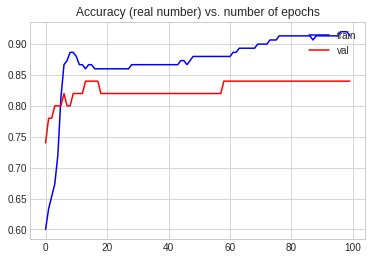

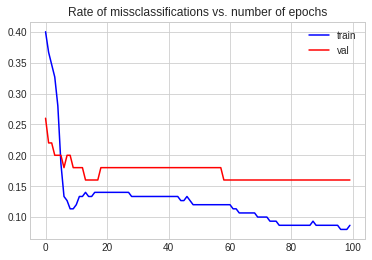

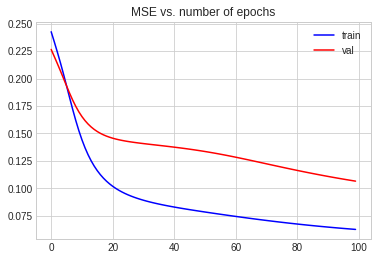

In [59]:
"""#combo 1. depends on weight init, may get stuck in local minima
input_layer_dim = dim
hidden_layer_dim = 20
learning_rate = 0.1
non_linearity = "tanh"
#optimizer = "sgd"
kwargs = {}
optimizer, kwargs["beta"] = "sgd_momentum", 0.9
epochs = 100"""

"""#combo 1.2. depends on weight init, may get stuck in local minima
input_layer_dim = dim
hidden_layer_dim = 3
learning_rate = 0.01
non_linearity = "tanh"
optimizer = "sgd"
kwargs = {}
#optimizer, kwargs["beta"] = "sgd_momentum", 0.9
epochs = 100"""

#combo 2. depends on weight init, may get stuck in local minima
input_layer_dim = dim
hidden_layer_dim = 3
learning_rate = 0.001
non_linearity = "sigmoid"
#optimizer = "sgd"
kwargs = {}
optimizer, kwargs["beta"] = "sgd_momentum", 0.9
epochs = 100

"""#combo 2.1. depends on weight init, may get stuck in local minima
input_layer_dim = dim
hidden_layer_dim = 10
learning_rate = 0.1
non_linearity = "sigmoid"
optimizer = "sgd"
kwargs = {}
#optimizer, kwargs["beta"] = "sgd_momentum", 0.9
epochs = 100"""


mlp = MultiLayerPerceptron(input_layer_dim, hidden_layer_dim, learning_rate, 
                           non_linearity, optimizer, **kwargs)
print(mlp)

batch_size = 50

mses_train = []
misclassifications_train = []
accuracies_train = []

mses_val = []
misclassifications_val = []
accuracies_val = []

targets_adjusted = targets.copy()
label_neg = -1

if non_linearity == "sigmoid":
    targets_adjusted[targets_adjusted == -1] = 0
    label_neg = 0

test_size = 0.25
input_data_train, targets_train, input_data_val, targets_val = \
    partition_train_val(input_data, targets_adjusted, test_size)
    
for i in range(epochs):
    
    # Assert that batch_size is okay
    assert input_data_train.shape[1] % batch_size == 0, \
        f"n_data is {input_data_train.shape[1]}, has to be divisible by batch_size = {batch_size}"
    n_batch = int(input_data_train.shape[1] / batch_size)

    # Iterate over mini-batches (if batch_size is the number of observations in the dataset, then 
    # it is batch mode, if batch_size = 1 then stochastic mode)
    print(f"epoch:{i+1}")

    for b in range(n_batch):
        input_data_batch = input_data_train[:, b*batch_size:(b+1)*batch_size]
        targets_batch = targets_train[b*batch_size:(b+1)*batch_size]
    
        out, oin, hout, hin = mlp.forward_pass(inputs=input_data_batch)
        delta_o, delta_h = mlp.backward_pass(out, oin, hout, hin, targets_batch)
        mlp.update_weights(input_data_batch, hout, delta_o, delta_h)
        
        print(f"\tbatch {b+1}/{n_batch}")
    
    accuracy_train, misclassification_train, mse_train = compute_metrics_mlp(mlp, input_data_train, targets_train)
    mses_train.append(mse_train)
    misclassification_rate_train = np.array(misclassification_train) / input_data_train.shape[1]
    misclassifications_train.append(misclassification_rate_train)
    accuracies_train.append(accuracy_train)
    
    accuracy_val, misclassification_val, mse_val = compute_metrics_mlp(mlp, input_data_val, targets_val)
    mses_val.append(mse_val)
    misclassification_rate_val = np.array(misclassification_val) / input_data_val.shape[1]
    misclassifications_val.append(misclassification_rate_val)
    accuracies_val.append(accuracy_val)
    
    if i % 10 == 0:
        plot_dec_boundary_mlp(mlp, input_data, targets_adjusted)
    
plot_mlp_accuracy_vs_n_epohcs(accuracies_train, accuracies_val)
plot_mlp_misclassification_vs_n_epohcs(misclassifications_train, misclassifications_val)
plot_mlp_mse_vs_n_epochs(mses_train, mses_val)

### 3.2.3 Function approximation

In [60]:
# Data generative functions
def gaussian_func(x,y):
    z = np.exp(-0.1*(np.square(x) + np.square(y))) - 0.5 
    return z

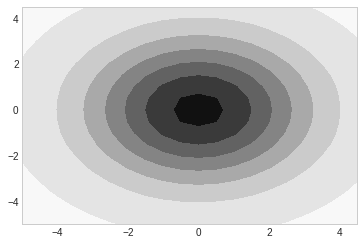

(20,)


In [61]:
x = np.arange(-5, 5, 0.5)
y = np.arange(-5, 5, 0.5)

xx, yy = np.meshgrid(x, y)

z = gaussian_func(xx,yy)

h = plt.contourf(x,y,z)
plt.show()

print(x.shape)

In [62]:
targets = z.reshape(-1)

input_data = np.vstack((xx.reshape(1,-1), yy.reshape(1,-1), np.ones(targets.shape[0])))
print(input_data.shape)
print(targets.shape)

print(targets.max())
print(targets.min())
print(input_data.shape)
dim = 2

(3, 400)
(400,)
0.5
-0.4932620530009145
(3, 400)


In [63]:
def viz_learned_func(x, y, out):
    x = np.arange(-5, 5, 0.5)
    y = np.arange(-5, 5, 0.5)
    n = x.shape[0]
    out_mesh = out.reshape(n,n)
    h = plt.contourf(x,y,out_mesh)
    plt.show()

input_layer: (100, 3)
input_layer: (1, 101)
sgd_momentum
tanh
(3, 324)
(3, 76)
epoch:1
	batch 1/1


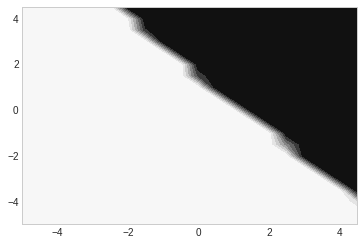

epoch:2
	batch 1/1
epoch:3
	batch 1/1
epoch:4
	batch 1/1
epoch:5
	batch 1/1
epoch:6
	batch 1/1
epoch:7
	batch 1/1
epoch:8
	batch 1/1
epoch:9
	batch 1/1
epoch:10
	batch 1/1
epoch:11
	batch 1/1


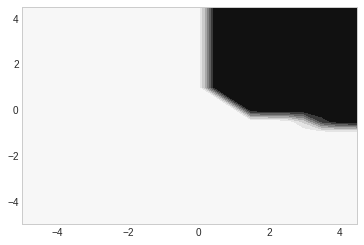

epoch:12
	batch 1/1
epoch:13
	batch 1/1
epoch:14
	batch 1/1
epoch:15
	batch 1/1
epoch:16
	batch 1/1
epoch:17
	batch 1/1
epoch:18
	batch 1/1
epoch:19
	batch 1/1
epoch:20
	batch 1/1
epoch:21
	batch 1/1


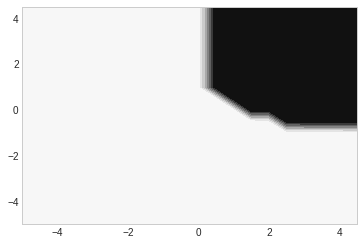

epoch:22
	batch 1/1
epoch:23
	batch 1/1
epoch:24
	batch 1/1
epoch:25
	batch 1/1
epoch:26
	batch 1/1
epoch:27
	batch 1/1
epoch:28
	batch 1/1
epoch:29
	batch 1/1
epoch:30
	batch 1/1
epoch:31
	batch 1/1


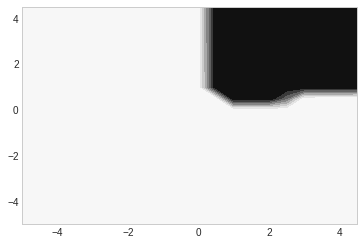

epoch:32
	batch 1/1
epoch:33
	batch 1/1
epoch:34
	batch 1/1
epoch:35
	batch 1/1
epoch:36
	batch 1/1
epoch:37
	batch 1/1
epoch:38
	batch 1/1
epoch:39
	batch 1/1
epoch:40
	batch 1/1
epoch:41
	batch 1/1


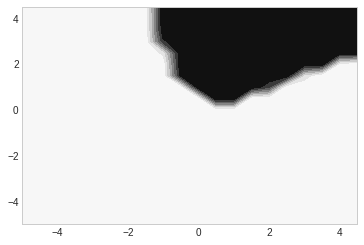

epoch:42
	batch 1/1
epoch:43
	batch 1/1
epoch:44
	batch 1/1
epoch:45
	batch 1/1
epoch:46
	batch 1/1
epoch:47
	batch 1/1
epoch:48
	batch 1/1
epoch:49
	batch 1/1
epoch:50
	batch 1/1
epoch:51
	batch 1/1


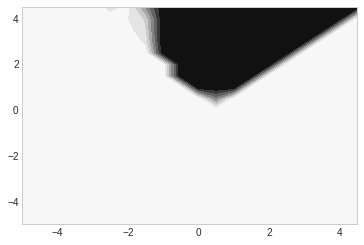

epoch:52
	batch 1/1
epoch:53
	batch 1/1
epoch:54
	batch 1/1
epoch:55
	batch 1/1
epoch:56
	batch 1/1
epoch:57
	batch 1/1
epoch:58
	batch 1/1
epoch:59
	batch 1/1
epoch:60
	batch 1/1
epoch:61
	batch 1/1


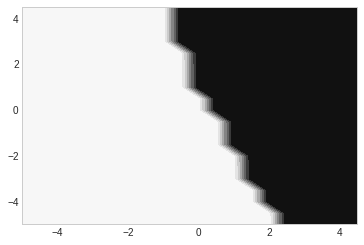

epoch:62
	batch 1/1
epoch:63
	batch 1/1
epoch:64
	batch 1/1
epoch:65
	batch 1/1
epoch:66
	batch 1/1
epoch:67
	batch 1/1
epoch:68
	batch 1/1
epoch:69
	batch 1/1
epoch:70
	batch 1/1
epoch:71
	batch 1/1


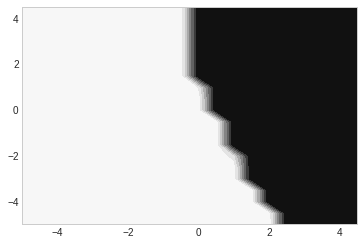

epoch:72
	batch 1/1
epoch:73
	batch 1/1
epoch:74
	batch 1/1
epoch:75
	batch 1/1
epoch:76
	batch 1/1
epoch:77
	batch 1/1
epoch:78
	batch 1/1
epoch:79
	batch 1/1
epoch:80
	batch 1/1
epoch:81
	batch 1/1


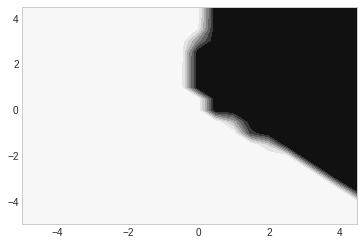

epoch:82
	batch 1/1
epoch:83
	batch 1/1
epoch:84
	batch 1/1
epoch:85
	batch 1/1
epoch:86
	batch 1/1
epoch:87
	batch 1/1
epoch:88
	batch 1/1
epoch:89
	batch 1/1
epoch:90
	batch 1/1
epoch:91
	batch 1/1


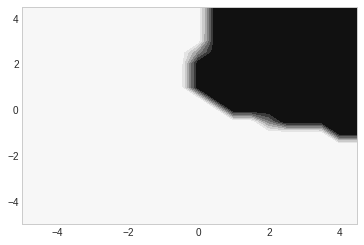

epoch:92
	batch 1/1
epoch:93
	batch 1/1
epoch:94
	batch 1/1
epoch:95
	batch 1/1
epoch:96
	batch 1/1
epoch:97
	batch 1/1
epoch:98
	batch 1/1
epoch:99
	batch 1/1
epoch:100
	batch 1/1
epoch:101
	batch 1/1


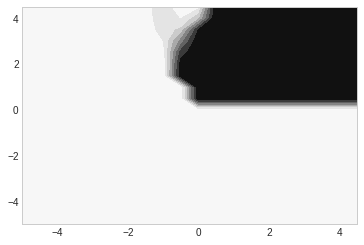

epoch:102
	batch 1/1
epoch:103
	batch 1/1
epoch:104
	batch 1/1
epoch:105
	batch 1/1
epoch:106
	batch 1/1
epoch:107
	batch 1/1
epoch:108
	batch 1/1
epoch:109
	batch 1/1
epoch:110
	batch 1/1
epoch:111
	batch 1/1


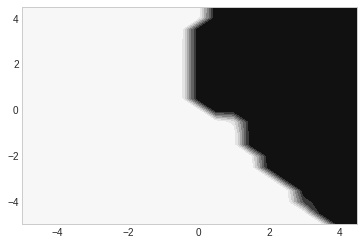

epoch:112
	batch 1/1
epoch:113
	batch 1/1
epoch:114
	batch 1/1
epoch:115
	batch 1/1
epoch:116
	batch 1/1
epoch:117
	batch 1/1
epoch:118
	batch 1/1
epoch:119
	batch 1/1
epoch:120
	batch 1/1
epoch:121
	batch 1/1


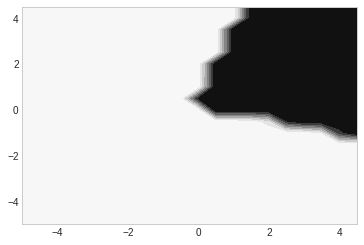

epoch:122
	batch 1/1
epoch:123
	batch 1/1
epoch:124
	batch 1/1
epoch:125
	batch 1/1
epoch:126
	batch 1/1
epoch:127
	batch 1/1
epoch:128
	batch 1/1
epoch:129
	batch 1/1
epoch:130
	batch 1/1
epoch:131
	batch 1/1


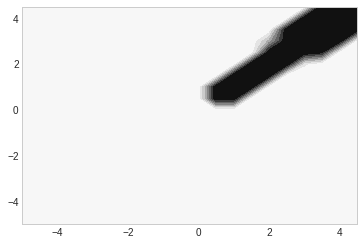

epoch:132
	batch 1/1
epoch:133
	batch 1/1
epoch:134
	batch 1/1
epoch:135
	batch 1/1
epoch:136
	batch 1/1
epoch:137
	batch 1/1
epoch:138
	batch 1/1
epoch:139
	batch 1/1
epoch:140
	batch 1/1
epoch:141
	batch 1/1


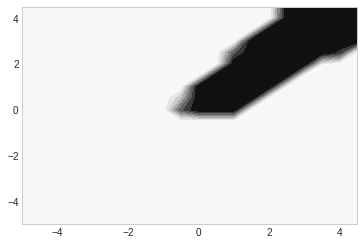

epoch:142
	batch 1/1
epoch:143
	batch 1/1
epoch:144
	batch 1/1
epoch:145
	batch 1/1
epoch:146
	batch 1/1
epoch:147
	batch 1/1
epoch:148
	batch 1/1
epoch:149
	batch 1/1
epoch:150
	batch 1/1
epoch:151
	batch 1/1


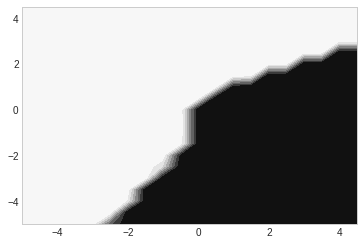

epoch:152
	batch 1/1
epoch:153
	batch 1/1
epoch:154
	batch 1/1
epoch:155
	batch 1/1
epoch:156
	batch 1/1
epoch:157
	batch 1/1
epoch:158
	batch 1/1
epoch:159
	batch 1/1
epoch:160
	batch 1/1
epoch:161
	batch 1/1


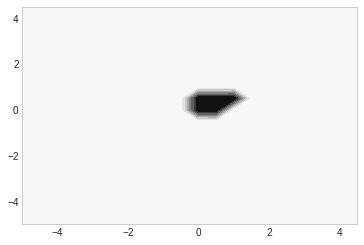

epoch:162
	batch 1/1
epoch:163
	batch 1/1
epoch:164
	batch 1/1
epoch:165
	batch 1/1
epoch:166
	batch 1/1
epoch:167
	batch 1/1
epoch:168
	batch 1/1
epoch:169
	batch 1/1
epoch:170
	batch 1/1
epoch:171
	batch 1/1


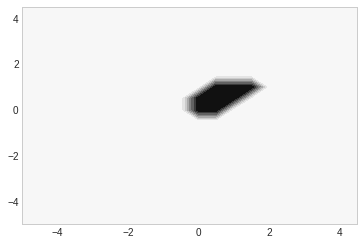

epoch:172
	batch 1/1
epoch:173
	batch 1/1
epoch:174
	batch 1/1
epoch:175
	batch 1/1
epoch:176
	batch 1/1
epoch:177
	batch 1/1
epoch:178
	batch 1/1
epoch:179
	batch 1/1
epoch:180
	batch 1/1
epoch:181
	batch 1/1


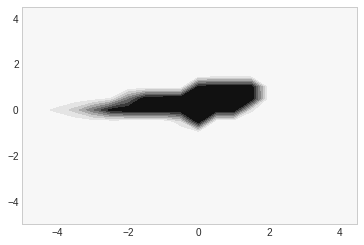

epoch:182
	batch 1/1
epoch:183
	batch 1/1
epoch:184
	batch 1/1
epoch:185
	batch 1/1
epoch:186
	batch 1/1
epoch:187
	batch 1/1
epoch:188
	batch 1/1
epoch:189
	batch 1/1
epoch:190
	batch 1/1
epoch:191
	batch 1/1


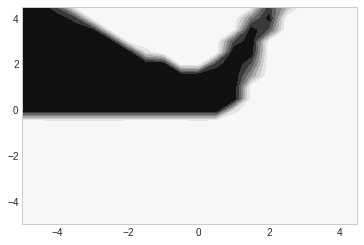

epoch:192
	batch 1/1
epoch:193
	batch 1/1
epoch:194
	batch 1/1
epoch:195
	batch 1/1
epoch:196
	batch 1/1
epoch:197
	batch 1/1
epoch:198
	batch 1/1
epoch:199
	batch 1/1
epoch:200
	batch 1/1
epoch:201
	batch 1/1


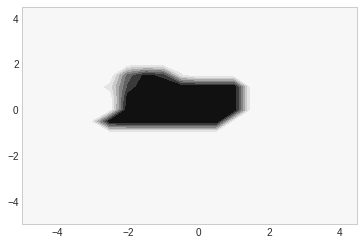

epoch:202
	batch 1/1
epoch:203
	batch 1/1
epoch:204
	batch 1/1
epoch:205
	batch 1/1
epoch:206
	batch 1/1
epoch:207
	batch 1/1
epoch:208
	batch 1/1
epoch:209
	batch 1/1
epoch:210
	batch 1/1
epoch:211
	batch 1/1


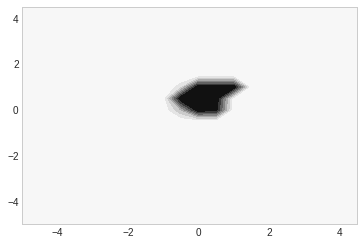

epoch:212
	batch 1/1
epoch:213
	batch 1/1
epoch:214
	batch 1/1
epoch:215
	batch 1/1
epoch:216
	batch 1/1
epoch:217
	batch 1/1
epoch:218
	batch 1/1
epoch:219
	batch 1/1
epoch:220
	batch 1/1
epoch:221
	batch 1/1


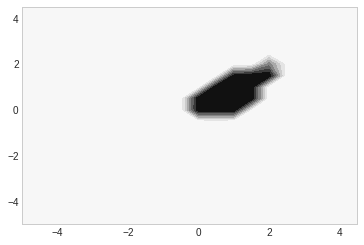

epoch:222
	batch 1/1
epoch:223
	batch 1/1
epoch:224
	batch 1/1
epoch:225
	batch 1/1
epoch:226
	batch 1/1
epoch:227
	batch 1/1
epoch:228
	batch 1/1
epoch:229
	batch 1/1
epoch:230
	batch 1/1
epoch:231
	batch 1/1


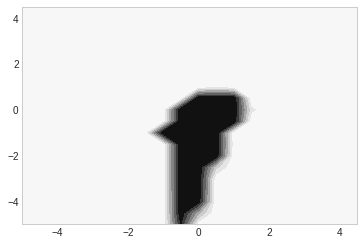

epoch:232
	batch 1/1
epoch:233
	batch 1/1
epoch:234
	batch 1/1
epoch:235
	batch 1/1
epoch:236
	batch 1/1
epoch:237
	batch 1/1
epoch:238
	batch 1/1
epoch:239
	batch 1/1
epoch:240
	batch 1/1
epoch:241
	batch 1/1


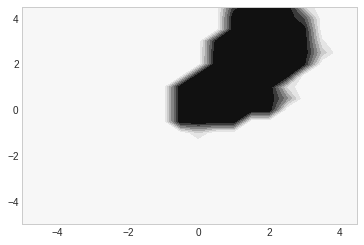

epoch:242
	batch 1/1
epoch:243
	batch 1/1
epoch:244
	batch 1/1
epoch:245
	batch 1/1
epoch:246
	batch 1/1
epoch:247
	batch 1/1
epoch:248
	batch 1/1
epoch:249
	batch 1/1
epoch:250
	batch 1/1
epoch:251
	batch 1/1


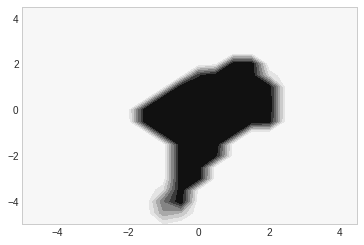

epoch:252
	batch 1/1
epoch:253
	batch 1/1
epoch:254
	batch 1/1
epoch:255
	batch 1/1
epoch:256
	batch 1/1
epoch:257
	batch 1/1
epoch:258
	batch 1/1
epoch:259
	batch 1/1
epoch:260
	batch 1/1
epoch:261
	batch 1/1


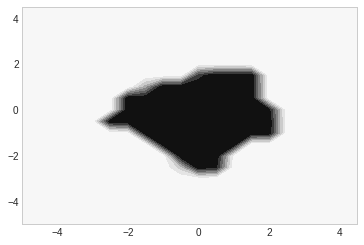

epoch:262
	batch 1/1
epoch:263
	batch 1/1
epoch:264
	batch 1/1
epoch:265
	batch 1/1
epoch:266
	batch 1/1
epoch:267
	batch 1/1
epoch:268
	batch 1/1
epoch:269
	batch 1/1
epoch:270
	batch 1/1
epoch:271
	batch 1/1


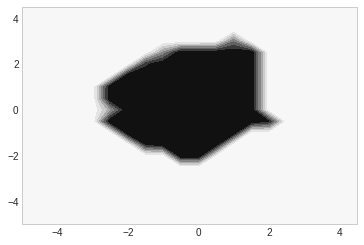

epoch:272
	batch 1/1
epoch:273
	batch 1/1
epoch:274
	batch 1/1
epoch:275
	batch 1/1
epoch:276
	batch 1/1
epoch:277
	batch 1/1
epoch:278
	batch 1/1
epoch:279
	batch 1/1
epoch:280
	batch 1/1
epoch:281
	batch 1/1


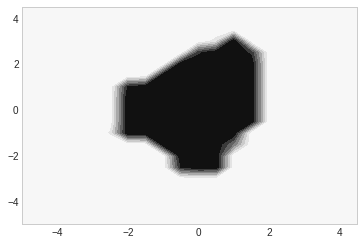

epoch:282
	batch 1/1
epoch:283
	batch 1/1
epoch:284
	batch 1/1
epoch:285
	batch 1/1
epoch:286
	batch 1/1
epoch:287
	batch 1/1
epoch:288
	batch 1/1
epoch:289
	batch 1/1
epoch:290
	batch 1/1
epoch:291
	batch 1/1


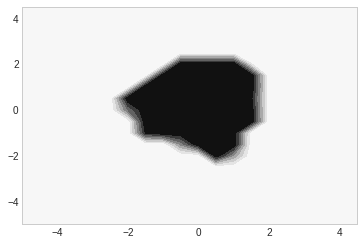

epoch:292
	batch 1/1
epoch:293
	batch 1/1
epoch:294
	batch 1/1
epoch:295
	batch 1/1
epoch:296
	batch 1/1
epoch:297
	batch 1/1
epoch:298
	batch 1/1
epoch:299
	batch 1/1
epoch:300
	batch 1/1
epoch:301
	batch 1/1


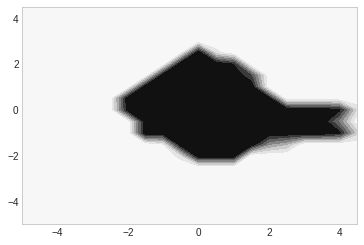

epoch:302
	batch 1/1
epoch:303
	batch 1/1
epoch:304
	batch 1/1
epoch:305
	batch 1/1
epoch:306
	batch 1/1
epoch:307
	batch 1/1
epoch:308
	batch 1/1
epoch:309
	batch 1/1
epoch:310
	batch 1/1
epoch:311
	batch 1/1


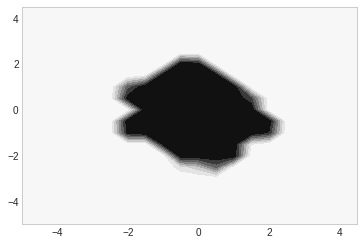

epoch:312
	batch 1/1
epoch:313
	batch 1/1
epoch:314
	batch 1/1
epoch:315
	batch 1/1
epoch:316
	batch 1/1
epoch:317
	batch 1/1
epoch:318
	batch 1/1
epoch:319
	batch 1/1
epoch:320
	batch 1/1
epoch:321
	batch 1/1


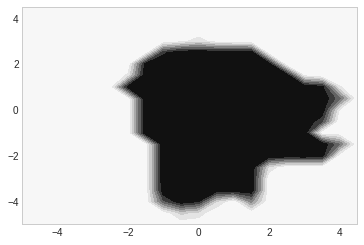

epoch:322
	batch 1/1
epoch:323
	batch 1/1
epoch:324
	batch 1/1
epoch:325
	batch 1/1
epoch:326
	batch 1/1
epoch:327
	batch 1/1
epoch:328
	batch 1/1
epoch:329
	batch 1/1
epoch:330
	batch 1/1
epoch:331
	batch 1/1


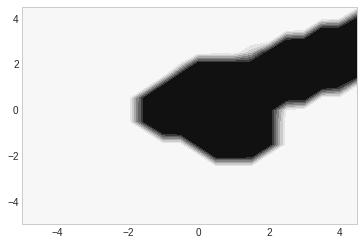

epoch:332
	batch 1/1
epoch:333
	batch 1/1
epoch:334
	batch 1/1
epoch:335
	batch 1/1
epoch:336
	batch 1/1
epoch:337
	batch 1/1
epoch:338
	batch 1/1
epoch:339
	batch 1/1
epoch:340
	batch 1/1
epoch:341
	batch 1/1


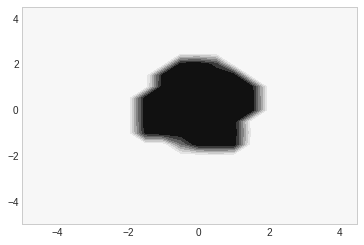

epoch:342
	batch 1/1
epoch:343
	batch 1/1
epoch:344
	batch 1/1
epoch:345
	batch 1/1
epoch:346
	batch 1/1
epoch:347
	batch 1/1
epoch:348
	batch 1/1
epoch:349
	batch 1/1
epoch:350
	batch 1/1
epoch:351
	batch 1/1


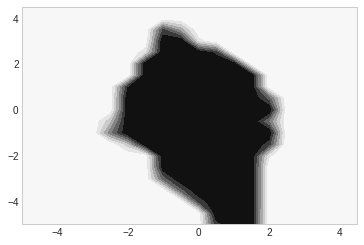

epoch:352
	batch 1/1
epoch:353
	batch 1/1
epoch:354
	batch 1/1
epoch:355
	batch 1/1
epoch:356
	batch 1/1
epoch:357
	batch 1/1
epoch:358
	batch 1/1
epoch:359
	batch 1/1
epoch:360
	batch 1/1
epoch:361
	batch 1/1


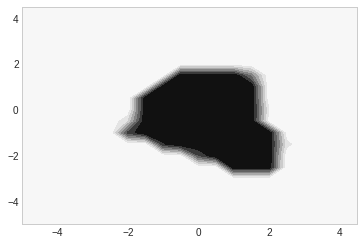

epoch:362
	batch 1/1
epoch:363
	batch 1/1
epoch:364
	batch 1/1
epoch:365
	batch 1/1
epoch:366
	batch 1/1
epoch:367
	batch 1/1
epoch:368
	batch 1/1
epoch:369
	batch 1/1
epoch:370
	batch 1/1
epoch:371
	batch 1/1


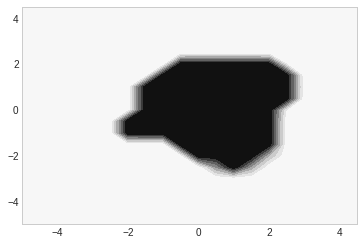

epoch:372
	batch 1/1
epoch:373
	batch 1/1
epoch:374
	batch 1/1
epoch:375
	batch 1/1
epoch:376
	batch 1/1
epoch:377
	batch 1/1
epoch:378
	batch 1/1
epoch:379
	batch 1/1
epoch:380
	batch 1/1
epoch:381
	batch 1/1


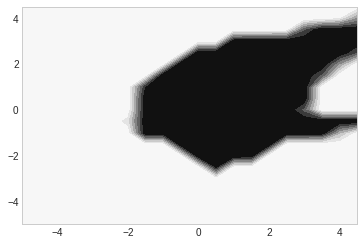

epoch:382
	batch 1/1
epoch:383
	batch 1/1
epoch:384
	batch 1/1
epoch:385
	batch 1/1
epoch:386
	batch 1/1
epoch:387
	batch 1/1
epoch:388
	batch 1/1
epoch:389
	batch 1/1
epoch:390
	batch 1/1
epoch:391
	batch 1/1


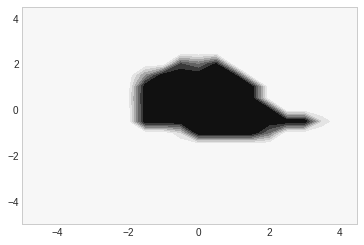

epoch:392
	batch 1/1
epoch:393
	batch 1/1
epoch:394
	batch 1/1
epoch:395
	batch 1/1
epoch:396
	batch 1/1
epoch:397
	batch 1/1
epoch:398
	batch 1/1
epoch:399
	batch 1/1
epoch:400
	batch 1/1
epoch:401
	batch 1/1


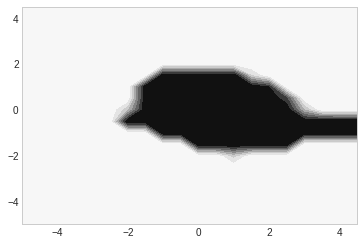

epoch:402
	batch 1/1
epoch:403
	batch 1/1
epoch:404
	batch 1/1
epoch:405
	batch 1/1
epoch:406
	batch 1/1
epoch:407
	batch 1/1
epoch:408
	batch 1/1
epoch:409
	batch 1/1
epoch:410
	batch 1/1
epoch:411
	batch 1/1


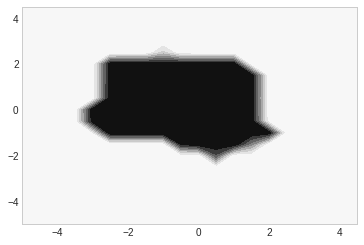

epoch:412
	batch 1/1
epoch:413
	batch 1/1
epoch:414
	batch 1/1
epoch:415
	batch 1/1
epoch:416
	batch 1/1
epoch:417
	batch 1/1
epoch:418
	batch 1/1
epoch:419
	batch 1/1
epoch:420
	batch 1/1
epoch:421
	batch 1/1


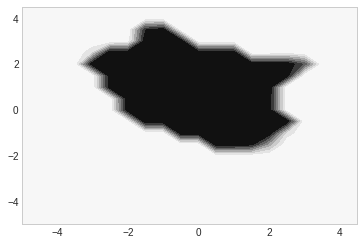

epoch:422
	batch 1/1
epoch:423
	batch 1/1
epoch:424
	batch 1/1
epoch:425
	batch 1/1
epoch:426
	batch 1/1
epoch:427
	batch 1/1
epoch:428
	batch 1/1
epoch:429
	batch 1/1
epoch:430
	batch 1/1
epoch:431
	batch 1/1


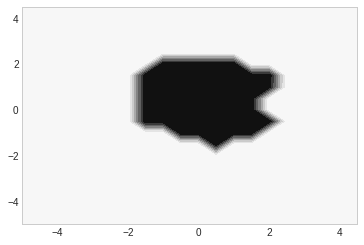

epoch:432
	batch 1/1
epoch:433
	batch 1/1
epoch:434
	batch 1/1
epoch:435
	batch 1/1
epoch:436
	batch 1/1
epoch:437
	batch 1/1
epoch:438
	batch 1/1
epoch:439
	batch 1/1
epoch:440
	batch 1/1
epoch:441
	batch 1/1


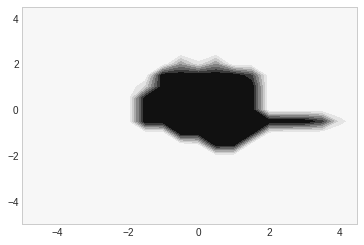

epoch:442
	batch 1/1
epoch:443
	batch 1/1
epoch:444
	batch 1/1
epoch:445
	batch 1/1
epoch:446
	batch 1/1
epoch:447
	batch 1/1
epoch:448
	batch 1/1
epoch:449
	batch 1/1
epoch:450
	batch 1/1
epoch:451
	batch 1/1


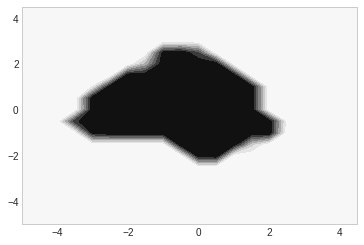

epoch:452
	batch 1/1
epoch:453
	batch 1/1
epoch:454
	batch 1/1
epoch:455
	batch 1/1
epoch:456
	batch 1/1
epoch:457
	batch 1/1
epoch:458
	batch 1/1
epoch:459
	batch 1/1
epoch:460
	batch 1/1
epoch:461
	batch 1/1


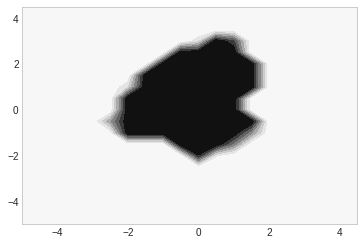

epoch:462
	batch 1/1
epoch:463
	batch 1/1
epoch:464
	batch 1/1
epoch:465
	batch 1/1
epoch:466
	batch 1/1
epoch:467
	batch 1/1
epoch:468
	batch 1/1
epoch:469
	batch 1/1
epoch:470
	batch 1/1
epoch:471
	batch 1/1


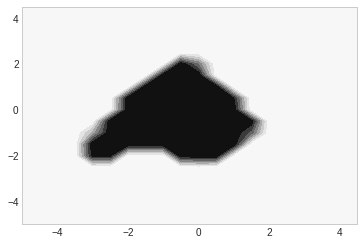

epoch:472
	batch 1/1
epoch:473
	batch 1/1
epoch:474
	batch 1/1
epoch:475
	batch 1/1
epoch:476
	batch 1/1
epoch:477
	batch 1/1
epoch:478
	batch 1/1
epoch:479
	batch 1/1
epoch:480
	batch 1/1
epoch:481
	batch 1/1


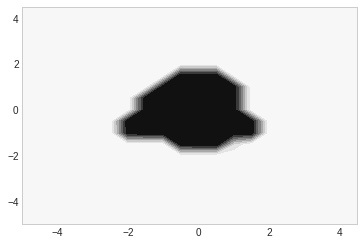

epoch:482
	batch 1/1
epoch:483
	batch 1/1
epoch:484
	batch 1/1
epoch:485
	batch 1/1
epoch:486
	batch 1/1
epoch:487
	batch 1/1
epoch:488
	batch 1/1
epoch:489
	batch 1/1
epoch:490
	batch 1/1
epoch:491
	batch 1/1


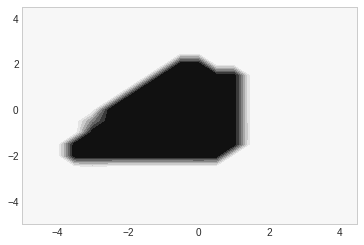

epoch:492
	batch 1/1
epoch:493
	batch 1/1
epoch:494
	batch 1/1
epoch:495
	batch 1/1
epoch:496
	batch 1/1
epoch:497
	batch 1/1
epoch:498
	batch 1/1
epoch:499
	batch 1/1
epoch:500
	batch 1/1


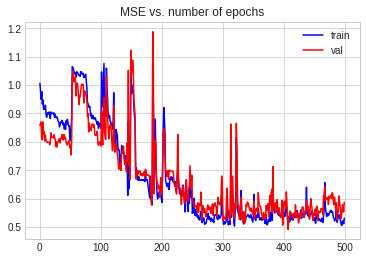

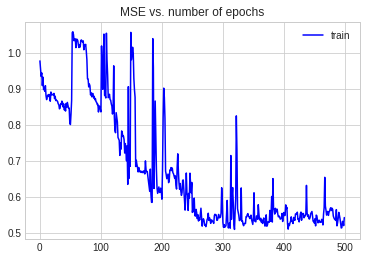

In [64]:
case = 6

if case == 1:
    #combo 1. depends on weight init, may get stuck in local minima
    input_layer_dim = dim
    hidden_layer_dim = 3
    learning_rate = 0.001
    non_linearity = "tanh"
    #optimizer = "sgd"
    kwargs = {}
    optimizer, kwargs["beta"] = "sgd_momentum", 0.9
    epochs = 500
elif case == 2:
    #combo 2. depends on weight init, may get stuck in local minima
    input_layer_dim = dim
    hidden_layer_dim = 5
    learning_rate = 0.001
    non_linearity = "tanh"
    #optimizer = "sgd"
    kwargs = {}
    optimizer, kwargs["beta"] = "sgd_momentum", 0.9
    epochs = 500
elif case == 3:
    #combo 3. depends on weight init, may get stuck in local minima
    input_layer_dim = dim
    hidden_layer_dim = 10
    learning_rate = 0.001
    non_linearity = "tanh"
    #optimizer = "sgd"
    kwargs = {}
    optimizer, kwargs["beta"] = "sgd_momentum", 0.9
    epochs = 500
elif case == 4:
    #combo 4. depends on weight init, may get stuck in local minima
    input_layer_dim = dim
    hidden_layer_dim = 15
    learning_rate = 0.001
    non_linearity = "tanh"
    #optimizer = "sgd"
    kwargs = {}
    optimizer, kwargs["beta"] = "sgd_momentum", 0.9
    epochs = 500
elif case == 5:
    #combo 5. depends on weight init, may get stuck in local minima
    input_layer_dim = dim
    hidden_layer_dim = 25
    learning_rate = 0.001
    non_linearity = "tanh"
    #optimizer = "sgd"
    kwargs = {}
    optimizer, kwargs["beta"] = "sgd_momentum", 0.9
    epochs = 500
elif case == 6:
    # very fast
    # batch size to 1!!!
    #combo 5. depends on weight init, may get stuck in local minima
    input_layer_dim = dim
    hidden_layer_dim = 100
    learning_rate = 0.1
    non_linearity = "tanh"
    #optimizer = "sgd"
    kwargs = {}
    optimizer, kwargs["beta"] = "sgd_momentum", 0.9
    epochs = 500
else:
    raise Exception

mlp = MultiLayerPerceptron(input_layer_dim, hidden_layer_dim, learning_rate, 
                           non_linearity, optimizer, **kwargs)
print(mlp)

batch_size = 324
#batch_size = 248
#batch_size = 96

mses_train = []
misclassifications_train = []
accuracies_train = []

mses_val = []
misclassifications_val = []
accuracies_val = []

mses_all = []

test_size = 0.19
#test_size = 0.38
#test_size = 0.76


input_data_train, targets_train, input_data_val, targets_val = \
    partition_train_val(input_data, targets, test_size, if_stratify=False)
    
for i in range(epochs):
    
    # Assert that batch_size is okay
    assert input_data_train.shape[1] % batch_size == 0, \
        f"n_data is {input_data_train.shape[1]}, has to be divisible by batch_size = {batch_size}"
    n_batch = int(input_data_train.shape[1] / batch_size)

    # Iterate over mini-batches (if batch_size is the number of observations in the dataset, then 
    # it is batch mode, if batch_size = 1 then stochastic mode)
    print(f"epoch:{i+1}")

    for b in range(n_batch):
        input_data_batch = input_data_train[:, b*batch_size:(b+1)*batch_size]
        targets_batch = targets_train[b*batch_size:(b+1)*batch_size]
    
        out, oin, hout, hin = mlp.forward_pass(inputs=input_data_batch)
        delta_o, delta_h = mlp.backward_pass(out, oin, hout, hin, targets_batch)
        mlp.update_weights(input_data_batch, hout, delta_o, delta_h)
        
        print(f"\tbatch {b+1}/{n_batch}")
    
    _, _, mse_train = compute_metrics_mlp(mlp, input_data_train, targets_train)
    mses_train.append(mse_train)
    
    _, _, mse_val = compute_metrics_mlp(mlp, input_data_val, targets_val)
    mses_val.append(mse_val)
    
    _, _, mse_all = compute_metrics_mlp(mlp, input_data, targets)
    mses_all.append(mse_all)
    
    if i % 10 == 0:
        out, _, _, _ = mlp.forward_pass(inputs=input_data)
        viz_learned_func(x, y, out)
    
plot_mlp_mse_vs_n_epochs(mses_train, mses_val)
plot_mlp_mse_vs_n_epochs(mses_all)